In [1]:
# Cell [1]
# ============================================================================
# MASTER CARDIAC ULTRASOUND ANALYSIS SYSTEM: CAMUS, Cactus, EchoNet Pediatric
# ============================================================================

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
from PIL import Image
from pathlib import Path
import cv2
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Using device: {DEVICE}")

# Dataset paths
CAMUS_DIR = "database_nifti"
CACTUS_DIR = "Cactus Dataset"
ECHONET_DIR = "/home/users/joshua04/141/data/raw/echonet_pediatric/PSAX"
PANECHO_ROOT = "/home/users/joshua04/141/PanEcho"

sys.path.append(PANECHO_ROOT)
sys.path.append(os.path.join(PANECHO_ROOT, "src"))

print("✅ Environment setup complete")
print(f"\n📁 Dataset Paths:")
print(f"   CAMUS:   {CAMUS_DIR}")
print(f"   CACTUS:  {CACTUS_DIR}")
print(f"   ECHONET: {ECHONET_DIR}")

🖥️  Using device: cuda
✅ Environment setup complete

📁 Dataset Paths:
   CAMUS:   database_nifti
   CACTUS:  Cactus Dataset
   ECHONET: /home/users/joshua04/141/data/raw/echonet_pediatric/PSAX


In [2]:
# Cell [2]
# ============================================================================
# CHOOSE DATASET TYPE
# ============================================================================

DATASET_TYPE = "ECHONET"      # Options: "CAMUS", "CACTUS", "ECHONET"
print(f"📊 Selected analysis for: {DATASET_TYPE}")

📊 Selected analysis for: ECHONET


In [3]:
# Cell [3]
# ============================================================================
# MODEL 1: U-NET SEGMENTATION MODEL (CAMUS)
# ============================================================================

class UNet(nn.Module):
    """U-Net for cardiac segmentation (LV, Myocardium, LA)"""
    def __init__(self, in_channels=1, out_channels=4):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        self.bottleneck = self.conv_block(512, 1024)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = self.conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        self.out = nn.Conv2d(64, out_channels, 1)
        self.pool = nn.MaxPool2d(2)
    
    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))
        d4 = self.upconv4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        d3 = self.upconv3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        return self.out(d1)

print("✅ U-Net segmentation model defined")

✅ U-Net segmentation model defined


In [4]:
# Cell [4]
# ============================================================================
# MODEL 2: CACTUS QUALITY ASSESSMENT MODEL
# ============================================================================

from torchvision.models import resnet18, ResNet18_Weights

class CactusQualityModel(nn.Module):
    """Multi-task model for ultrasound quality grading"""
    def __init__(self):
        super(CactusQualityModel, self).__init__()
        self.backbone = resnet18(weights=ResNet18_Weights.DEFAULT)
        feat_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.grade_head = nn.Linear(feat_dim, 1)
        self.quality_head = nn.Linear(feat_dim, 3)
    
    def forward(self, x):
        features = self.backbone(x)
        grade = self.grade_head(features)
        quality_logits = self.quality_head(features)
        return grade, quality_logits

print("✅ Cactus quality assessment model defined")

✅ Cactus quality assessment model defined


In [5]:
# Cell [5]
# ============================================================================
# MODEL 3: ECHONET EF PREDICTION MODEL
# ============================================================================

from src.models import FrameTransformer

class EFPredictionModel(nn.Module):
    """Video-based EF prediction using FrameTransformer"""
    def __init__(self):
        super(EFPredictionModel, self).__init__()
        self.backbone = FrameTransformer(
            arch="convnext_tiny",
            n_heads=8,
            n_layers=2,
            transformer_dropout=0.1,
            pooling="mean",
            clip_len=16)
        self.fc = nn.Linear(768, 1)
    
    def forward(self, x):
        features = self.backbone(x)
        return self.fc(features)

print("✅ EF prediction model defined")

✅ EF prediction model defined


In [6]:
# Cell [6]
# ============================================================================
# LOAD PRETRAINED MODELS
# ============================================================================

def load_segment_model():
    """Load U-Net segmentation model"""
    model = UNet().to(DEVICE)
    path = "checkpoints/segmentation_model.pt"
    if os.path.exists(path):
        model.load_state_dict(torch.load(path, map_location=DEVICE, weights_only=True))
        model.eval()
        print("✅ Segmentation model loaded")
        return model
    else:
        print("⚠️  Segmentation model not found")
        return None

def load_cactus_model():
    """Load Cactus quality assessment model"""
    model = CactusQualityModel().to(DEVICE)
    path = "cactus_pretrain_5epochs.pt"
    if os.path.exists(path):
        model.load_state_dict(torch.load(path, map_location=DEVICE, weights_only=True))
        model.eval()
        print("✅ Cactus quality model loaded")
        return model
    else:
        print("⚠️  Cactus quality model not found")
        return None

def load_ef_model():
    """Load EchoNet EF prediction model"""
    model = EFPredictionModel().to(DEVICE)
    path = "/home/users/joshua04/141/results/ef_frozen_head.pt"
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=DEVICE, weights_only=True)
        new_state_dict = {}
        for key, value in checkpoint.items():
            if key.startswith("0."):
                new_key = "backbone." + key[2:]
            elif key.startswith("1."):
                new_key = "fc." + key[2:]
            else:
                new_key = key
            new_state_dict[new_key] = value
        model.load_state_dict(new_state_dict)
        model.eval()
        print("✅ EF prediction model loaded")
        return model
    else:
        print("⚠️  EF model not found")
        return None

# Load all models
seg_model = load_segment_model()
cactus_model = load_cactus_model()
ef_model = load_ef_model()

✅ Segmentation model loaded
✅ Cactus quality model loaded
✅ EF prediction model loaded


In [7]:
# Cell [7]
# ============================================================================
# CAMUS UTILITY FUNCTIONS
# ============================================================================

def explore_camus(data_dir):
    """Explore CAMUS dataset structure"""
    if not os.path.exists(data_dir):
        print(f"❌ Directory {data_dir} not found!")
        return []
    patients = sorted([d for d in os.listdir(data_dir)
                      if os.path.isdir(os.path.join(data_dir, d)) and d.startswith('patient')])
    print(f"📊 Found {len(patients)} patients in CAMUS")
    return patients

def load_image(pid, view="2CH", phase="ED", data_dir=CAMUS_DIR):
    """Load cardiac image"""
    path = os.path.join(data_dir, pid, f"{pid}_{view}_{phase}.nii.gz")
    if not os.path.exists(path):
        return None
    return nib.load(path).get_fdata()

def load_mask(pid, view="2CH", phase="ED", data_dir=CAMUS_DIR):
    """Load segmentation mask"""
    path = os.path.join(data_dir, pid, f"{pid}_{view}_{phase}_gt.nii.gz")
    if not os.path.exists(path):
        return None
    return nib.load(path).get_fdata()

def lv_area_mm2(pid, view="2CH", phase="ED", data_dir=CAMUS_DIR):
    """Calculate LV cavity area in mm²"""
    img_path = os.path.join(data_dir, pid, f"{pid}_{view}_{phase}.nii.gz")
    mask_path = os.path.join(data_dir, pid, f"{pid}_{view}_{phase}_gt.nii.gz")
    if not os.path.exists(img_path) or not os.path.exists(mask_path):
        return None
    img_nii = nib.load(img_path)
    mask = nib.load(mask_path).get_fdata()
    dx, dy = img_nii.header.get_zooms()[:2]
    lv_pixels = (mask == 1).sum()
    return lv_pixels * dx * dy

def lv_length_mm(pid, view="4CH", phase="ED", data_dir=CAMUS_DIR):
    """Calculate LV long-axis length in mm"""
    img_path = os.path.join(data_dir, pid, f"{pid}_{view}_{phase}.nii.gz")
    mask_path = os.path.join(data_dir, pid, f"{pid}_{view}_{phase}_gt.nii.gz")
    if not os.path.exists(img_path) or not os.path.exists(mask_path):
        return None
    img_nii = nib.load(img_path)
    mask = nib.load(mask_path).get_fdata()
    dx, dy = img_nii.header.get_zooms()[:2]
    ys, xs = np.where(mask == 1)
    if len(xs) == 0:
        return None
    length_pixels = np.sqrt((xs.max() - xs.min()) ** 2 + (ys.max() - ys.min()) ** 2)
    return length_pixels * np.mean([dx, dy])

def lv_volume_ml(pid, phase="ED", data_dir=CAMUS_DIR):
    """Calculate LV volume in mL using biplane area-length method"""
    A_2ch = lv_area_mm2(pid, "2CH", phase, data_dir)
    A_4ch = lv_area_mm2(pid, "4CH", phase, data_dir)
    L = lv_length_mm(pid, "4CH", phase, data_dir)
    if None in [A_2ch, A_4ch, L]:
        return None
    V_mm3 = (8 / (3 * np.pi)) * (A_2ch * A_4ch) / L
    return V_mm3 / 1000

def calculate_cardiac_metrics(pid, data_dir=CAMUS_DIR):
    """Calculate comprehensive cardiac metrics"""
    edv = lv_volume_ml(pid, "ED", data_dir)
    esv = lv_volume_ml(pid, "ES", data_dir)
    if None in [edv, esv]:
        return None
    sv = edv - esv
    ef = (sv / edv) * 100
    return {"EDV": edv, "ESV": esv, "SV": sv, "EF": ef}

def cardiac_output_L_min(sv_ml, hr_bpm):
    """Calculate Cardiac Output in L/min"""
    return (sv_ml * hr_bpm) / 1000

print("✅ CAMUS utility functions loaded")

✅ CAMUS utility functions loaded


In [8]:
# Cell [8]
# ============================================================================
# CROSS-DATASET UTILITY FUNCTIONS
# ============================================================================

from torchvision import transforms
import torchvision.transforms.functional as TF

def extract_frame_from_video(video_path, frame_idx=0):
    """Extract a single frame from video (.avi or .mp4) as grayscale for segmentation"""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        return None
    
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    return gray

def preprocess_for_segmentation(img_array, target_size=(256, 256)):
    """
    Preprocess any image (from video frame, CAMUS, or Cactus) for U-Net segmentation
    Input: numpy array (H, W) grayscale or (H, W, 3) color
    Output: torch tensor (1, 1, H, W) normalized
    """
    # Convert to grayscale if color
    if len(img_array.shape) == 3:
        img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    
    # Normalize to [0, 1]
    img_norm = (img_array - img_array.min()) / (img_array.max() - img_array.min() + 1e-8)
    
    # Convert to PIL Image for transform
    img_pil = Image.fromarray((img_norm * 255).astype(np.uint8))
    
    # Resize
    img_resized = TF.resize(img_pil, target_size, interpolation=Image.BILINEAR)
    
    # To tensor
    img_tensor = TF.to_tensor(img_resized)
    
    return img_tensor.unsqueeze(0)  # (1, 1, H, W)

def segment_image(model, img_tensor):
    """
    Run segmentation on preprocessed image tensor
    Returns: segmentation mask as numpy array
    """
    if model is None:
        return None
    
    with torch.no_grad():
        img_tensor = img_tensor.to(DEVICE)
        output = model(img_tensor)
        pred_mask = torch.argmax(output, dim=1).cpu().numpy()[0]
    
    return pred_mask

def calculate_metrics_from_mask(mask, pixel_spacing_mm=(1.0, 1.0)):
    """
    Calculate cardiac metrics from segmentation mask
    mask: 2D numpy array with labels (0=background, 1=LV, 2=myocardium, 3=LA)
    pixel_spacing_mm: (dx, dy) in mm
    """
    dx, dy = pixel_spacing_mm
    pixel_area_mm2 = dx * dy
    
    # LV area
    lv_pixels = (mask == 1).sum()
    lv_area = lv_pixels * pixel_area_mm2
    
    # LV length (approximation)
    ys, xs = np.where(mask == 1)
    if len(xs) == 0:
        return None
    
    lv_length = np.sqrt((xs.max() - xs.min()) ** 2 + (ys.max() - ys.min()) ** 2) * np.mean([dx, dy])
    
    return {
        "lv_area_mm2": lv_area,
        "lv_length_mm": lv_length,
        "lv_pixels": lv_pixels
    }

def preprocess_for_quality(img_array, is_video_frame=False):
    """
    Preprocess image for Cactus quality model
    Input: numpy array (H, W) grayscale or (H, W, 3) RGB
    Output: torch tensor (1, 3, 224, 224)
    """
    # Convert grayscale to RGB if needed
    if len(img_array.shape) == 2:
        img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
    elif img_array.shape[2] == 1:
        img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
    
    # Convert to PIL
    img_pil = Image.fromarray(img_array.astype(np.uint8))
    
    # Transform
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    
    img_tensor = transform(img_pil).unsqueeze(0)
    return img_tensor

def assess_quality(model, img_tensor):
    """
    Assess image quality using Cactus model
    Returns: dict with grade, quality label, and confidence
    """
    if model is None:
        return None
    
    QUALITY_LABELS = ["Bad", "Okay", "Good"]
    
    with torch.no_grad():
        img_tensor = img_tensor.to(DEVICE)
        pred_grade, pred_quality = model(img_tensor)
        grade = float(torch.clamp(pred_grade, 1.0, 10.0).item())
        probs = torch.softmax(pred_quality, dim=1)
        conf, cls = torch.max(probs, dim=1)
    
    return {
        "grade": round(grade),
        "quality": QUALITY_LABELS[cls.item()],
        "confidence": conf.item()
    }

def read_video_frames_for_ef(path, n_frames=16):
    """Extract frames from video (.avi or .mp4) for EF prediction"""
    import torchvision.transforms as T
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        return None
    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idxs = np.linspace(0, max(length - 1, 0), n_frames).astype(int)
    
    frames = []
    i = 0
    while True:
        ok, frame = cap.read()
        if not ok:
            break
        if i in idxs:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(transform(frame))
        i += 1
    cap.release()
    
    while len(frames) < n_frames:
        frames.append(frames[-1])
    
    return torch.stack(frames, dim=1)  # (3, T, 224, 224)

def predict_ef(model, video_tensor):
    """Predict EF from video tensor"""
    if model is None:
        return None
    
    with torch.no_grad():
        video_tensor = video_tensor.unsqueeze(0).to(DEVICE)
        ef = model(video_tensor)
    
    return ef.item()

print("✅ Cross-dataset utility functions loaded")

✅ Cross-dataset utility functions loaded


In [9]:
# Cell [9]
# ============================================================================
# UNIFIED ANALYSIS: ALL MODELS ON SELECTED DATASET
# ============================================================================

def analyze_camus_complete():
    """Run all analyses on CAMUS dataset"""
    print("\n" + "="*70)
    print("🫀 COMPREHENSIVE CAMUS ANALYSIS")
    print("="*70 + "\n")
    
    patients = explore_camus(CAMUS_DIR)
    if not patients:
        return None
    
    results = []
    
    for pid in patients[:5]:
        print(f"\n{'='*70}")
        print(f"Analyzing {pid}")
        print(f"{'='*70}")
        
        # 1. Cardiac Metrics (from ground truth masks)
        metrics = calculate_cardiac_metrics(pid, CAMUS_DIR)
        
        if metrics:
            print(f"\n📊 Cardiac Metrics (Ground Truth):")
            print(f"  EDV: {metrics['EDV']:.1f} mL")
            print(f"  ESV: {metrics['ESV']:.1f} mL")
            print(f"  SV:  {metrics['SV']:.1f} mL")
            print(f"  EF:  {metrics['EF']:.1f}%")
            co = cardiac_output_L_min(metrics['SV'], 75)
            print(f"  CO:  {co:.2f} L/min (@ 75 bpm)")
        
        # 2. Segmentation (predict with U-Net on 4CH ED)
        seg_metrics = None
        if seg_model is not None:
            img = load_image(pid, "4CH", "ED", CAMUS_DIR)
            if img is not None:
                img_tensor = preprocess_for_segmentation(img)
                pred_mask = segment_image(seg_model, img_tensor)
                seg_metrics = calculate_metrics_from_mask(pred_mask, pixel_spacing_mm=(1.5, 1.5))
                
                print(f"\n🔍 Segmentation Metrics (U-Net Prediction):")
                if seg_metrics:
                    print(f"  LV Area: {seg_metrics['lv_area_mm2']:.1f} mm²")
                    print(f"  LV Length: {seg_metrics['lv_length_mm']:.1f} mm")
        
        # 3. Quality Assessment
        quality_result = None
        if cactus_model is not None:
            img = load_image(pid, "4CH", "ED", CAMUS_DIR)
            if img is not None:
                # Convert to RGB for quality model
                img_rgb = np.stack([img]*3, axis=-1)
                img_rgb = ((img_rgb - img_rgb.min()) / (img_rgb.max() - img_rgb.min() + 1e-8) * 255).astype(np.uint8)
                quality_tensor = preprocess_for_quality(img_rgb)
                quality_result = assess_quality(cactus_model, quality_tensor)
                
                print(f"\n⭐ Image Quality Assessment:")
                if quality_result:
                    print(f"  Quality: {quality_result['quality']}")
                    print(f"  Grade: {quality_result['grade']}/10")
                    print(f"  Confidence: {quality_result['confidence']:.2%}")
        
        # Build result dictionary
        result = {"patient": pid, "dataset": "CAMUS"}
        
        if metrics:
            result.update(metrics)
        
        result["segmentation"] = seg_metrics
        result["quality"] = quality_result
        
        results.append(result)
    
    return results

def analyze_cactus_complete():
    """Run all analyses on Cactus dataset"""
    print("\n" + "="*70)
    print("🔍 COMPREHENSIVE CACTUS ANALYSIS")
    print("="*70 + "\n")
    
    image_dir = os.path.join(CACTUS_DIR, "Images Dataset", "A4C")
    if not os.path.exists(image_dir):
        print(f"❌ Directory not found: {image_dir}")
        return None
    
    image_files = [os.path.join(image_dir, f)
                   for f in os.listdir(image_dir)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:5]
    
    results = []
    
    for img_path in image_files:
        print(f"\n{'='*70}")
        print(f"Analyzing {os.path.basename(img_path)}")
        print(f"{'='*70}")
        
        # Load image
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # 1. Quality Assessment (primary task for Cactus)
        quality_result = None
        if cactus_model is not None:
            quality_tensor = preprocess_for_quality(img_rgb)
            quality_result = assess_quality(cactus_model, quality_tensor)
            
            print(f"\n⭐ Image Quality Assessment:")
            if quality_result:
                print(f"  Quality: {quality_result['quality']}")
                print(f"  Grade: {quality_result['grade']}/10")
                print(f"  Confidence: {quality_result['confidence']:.2%}")
        
        # 2. Segmentation (apply U-Net trained on CAMUS)
        seg_metrics = None
        if seg_model is not None:
            seg_tensor = preprocess_for_segmentation(img_gray)
            pred_mask = segment_image(seg_model, seg_tensor)
            seg_metrics = calculate_metrics_from_mask(pred_mask, pixel_spacing_mm=(0.5, 0.5))
            
            print(f"\n🔍 Segmentation Metrics (Cross-domain):")
            if seg_metrics:
                print(f"  LV Area: {seg_metrics['lv_area_mm2']:.1f} mm²")
                print(f"  LV Length: {seg_metrics['lv_length_mm']:.1f} mm")
                print(f"  Note: Metrics are approximate (trained on CAMUS)")
        
        result = {
            "image": os.path.basename(img_path),
            "dataset": "CACTUS",
            "quality": quality_result,
            "segmentation": seg_metrics
        }
        results.append(result)
    
    return results

def analyze_echonet_complete():
    """Run all analyses on EchoNet dataset - SUPPORTS .AVI and .MP4"""
    print("\n" + "="*70)
    print("🎥 COMPREHENSIVE ECHONET ANALYSIS")
    print("="*70 + "\n")
    
    video_folder = os.path.join(ECHONET_DIR, "Videos")
    if not os.path.exists(video_folder):
        print(f"❌ Video folder not found: {video_folder}")
        return None
    
    # Look for .avi and .mp4 files
    video_files = [os.path.join(video_folder, f)
                   for f in os.listdir(video_folder)
                   if f.endswith(('.avi', '.mp4'))][:3]
    
    if not video_files:
        print(f"❌ No video files (.avi or .mp4) found in {video_folder}")
        return None
    
    print(f"✅ Found {len(video_files)} videos")
    
    results = []
    
    for video_path in video_files:
        print(f"\n{'='*70}")
        print(f"Analyzing {os.path.basename(video_path)}")
        print(f"{'='*70}")
        
        # Check if video can be opened
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"⚠️  Could not open video: {video_path}")
            continue
        
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        cap.release()
        
        if total_frames == 0:
            print(f"⚠️  Video has 0 frames: {video_path}")
            continue
        
        print(f"   Total frames: {total_frames}")
        print(f"   FPS: {fps:.1f}")
        
        # 1. EF Prediction (primary task for EchoNet)
        ef_value = None
        if ef_model is not None:
            try:
                print("\n💓 Running EF prediction...")
                video_tensor = read_video_frames_for_ef(video_path, n_frames=16)
                if video_tensor is not None:
                    ef_value = predict_ef(ef_model, video_tensor)
                    print(f"   Predicted EF: {ef_value:.2f}%")
                    
                    # Clinical interpretation
                    if ef_value >= 55:
                        print(f"   Status: ✅ Normal")
                    elif ef_value >= 50:
                        print(f"   Status: ⚠️  Borderline")
                    else:
                        print(f"   Status: ❌ Reduced")
            except Exception as e:
                print(f"   ⚠️  EF prediction failed: {e}")
        
        # 2. Quality Assessment (on middle frame)
        quality_result = None
        if cactus_model is not None:
            try:
                print("\n⭐ Assessing quality...")
                cap = cv2.VideoCapture(video_path)
                cap.set(cv2.CAP_PROP_POS_FRAMES, total_frames // 2)
                ret, frame = cap.read()
                cap.release()
                
                if ret:
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    quality_tensor = preprocess_for_quality(frame_rgb, is_video_frame=True)
                    quality_result = assess_quality(cactus_model, quality_tensor)
                    
                    if quality_result:
                        print(f"   Quality: {quality_result['quality']}")
                        print(f"   Grade: {quality_result['grade']}/10")
                        print(f"   Confidence: {quality_result['confidence']:.2%}")
            except Exception as e:
                print(f"   ⚠️  Quality assessment failed: {e}")
        
        # 3. Segmentation (on middle frame)
        seg_metrics = None
        if seg_model is not None:
            try:
                print("\n🔍 Running segmentation...")
                frame_gray = extract_frame_from_video(video_path, frame_idx=total_frames // 2)
                if frame_gray is not None:
                    seg_tensor = preprocess_for_segmentation(frame_gray)
                    pred_mask = segment_image(seg_model, seg_tensor)
                    seg_metrics = calculate_metrics_from_mask(pred_mask, pixel_spacing_mm=(0.5, 0.5))
                    
                    if seg_metrics:
                        print(f"   LV Area: {seg_metrics['lv_area_mm2']:.1f} mm²")
                        print(f"   LV Length: {seg_metrics['lv_length_mm']:.1f} mm")
                        print(f"   ⚠️  Note: Cross-domain (trained on CAMUS)")
            except Exception as e:
                print(f"   ⚠️  Segmentation failed: {e}")
        
        result = {
            "video": os.path.basename(video_path),
            "video_path": video_path,
            "dataset": "ECHONET",
            "total_frames": total_frames,
            "fps": fps,
            "predicted_ef": ef_value,
            "quality": quality_result,
            "segmentation": seg_metrics
        }
        results.append(result)
    
    return results

# Initialize all_results as None
all_results = None

# Run comprehensive analysis based on selected dataset
print(f"\n🔄 Running analysis for {DATASET_TYPE} dataset...")

if DATASET_TYPE == "CAMUS":
    all_results = analyze_camus_complete()
elif DATASET_TYPE == "CACTUS":
    all_results = analyze_cactus_complete()
elif DATASET_TYPE == "ECHONET":
    all_results = analyze_echonet_complete()
else:
    print("❌ Invalid DATASET_TYPE. Choose 'CAMUS', 'CACTUS', or 'ECHONET'")

# Print completion status
if all_results:
    print(f"\n✅ Analysis complete! Analyzed {len(all_results)} samples.")
    print(f"💡 Now run the visualization cells (Cell 17-22) to see results!")
else:
    print(f"\n⚠️  No results generated. Check dataset path and try again.")


🔄 Running analysis for ECHONET dataset...

🎥 COMPREHENSIVE ECHONET ANALYSIS

✅ Found 3 videos

Analyzing CR32a95c6-CR4884f36-000033.avi
   Total frames: 99
   FPS: 68.0

💓 Running EF prediction...
   Predicted EF: 51.96%
   Status: ⚠️  Borderline

⭐ Assessing quality...
   Quality: Bad
   Grade: 3/10
   Confidence: 70.79%

🔍 Running segmentation...
   LV Area: 1170.8 mm²
   LV Length: 99.6 mm
   ⚠️  Note: Cross-domain (trained on CAMUS)

Analyzing CR32a95d2-CR3dcb631-000031.avi
   Total frames: 401
   FPS: 73.0

💓 Running EF prediction...
   Predicted EF: 55.27%
   Status: ✅ Normal

⭐ Assessing quality...
   Quality: Bad
   Grade: 4/10
   Confidence: 67.73%

🔍 Running segmentation...
   LV Area: 569.5 mm²
   LV Length: 44.4 mm
   ⚠️  Note: Cross-domain (trained on CAMUS)

Analyzing CR3dcb0e4-CR3dcb2a4-000024.avi
   Total frames: 77
   FPS: 50.0

💓 Running EF prediction...
   Predicted EF: 56.07%
   Status: ✅ Normal

⭐ Assessing quality...
   Quality: Good
   Grade: 4/10
   Confidence:

In [10]:
# Cell [10] - FIXED VERSION
# ============================================================================
# VISUALIZATION: Segmentation Overlay - FIXED FOR PROPER ALIGNMENT
# ============================================================================

def visualize_segmentation_overlay(img_array, pred_mask, title="Segmentation Overlay"):
    """
    Visualize image with segmentation overlay - FIXED to handle size mismatch
    img_array: original image (H, W) or (H, W, 3)
    pred_mask: predicted segmentation (H, W) with labels 0-3
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Get original image dimensions
    if len(img_array.shape) == 2:
        orig_h, orig_w = img_array.shape
    else:
        orig_h, orig_w = img_array.shape[:2]
    
    # Resize mask back to original image size
    from PIL import Image
    pred_mask_resized = np.array(Image.fromarray(pred_mask.astype(np.uint8)).resize(
        (orig_w, orig_h), 
        resample=Image.NEAREST
    ))
    
    # Original image
    if len(img_array.shape) == 2:
        axes[0].imshow(img_array, cmap='gray')
    else:
        axes[0].imshow(img_array)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Segmentation mask (resized)
    axes[1].imshow(pred_mask_resized, cmap='jet')
    axes[1].set_title('Segmentation Mask')
    axes[1].axis('off')
    
    # Overlay - NOW WITH PROPER ALIGNMENT
    if len(img_array.shape) == 2:
        axes[2].imshow(img_array, cmap='gray')
    else:
        axes[2].imshow(img_array)
    
    # Create colored masks from resized segmentation
    lv_mask = (pred_mask_resized == 1).astype(float)
    myo_mask = (pred_mask_resized == 2).astype(float)
    la_mask = (pred_mask_resized == 3).astype(float)
    
    # Overlay with transparency
    axes[2].imshow(lv_mask, alpha=0.4, cmap='Reds')
    axes[2].imshow(myo_mask, alpha=0.3, cmap='Blues')
    axes[2].imshow(la_mask, alpha=0.3, cmap='Greens')
    axes[2].set_title('Overlay (Red=LV, Blue=Myo, Green=LA)')
    axes[2].axis('off')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("✅ Fixed visualization function loaded")

✅ Fixed visualization function loaded


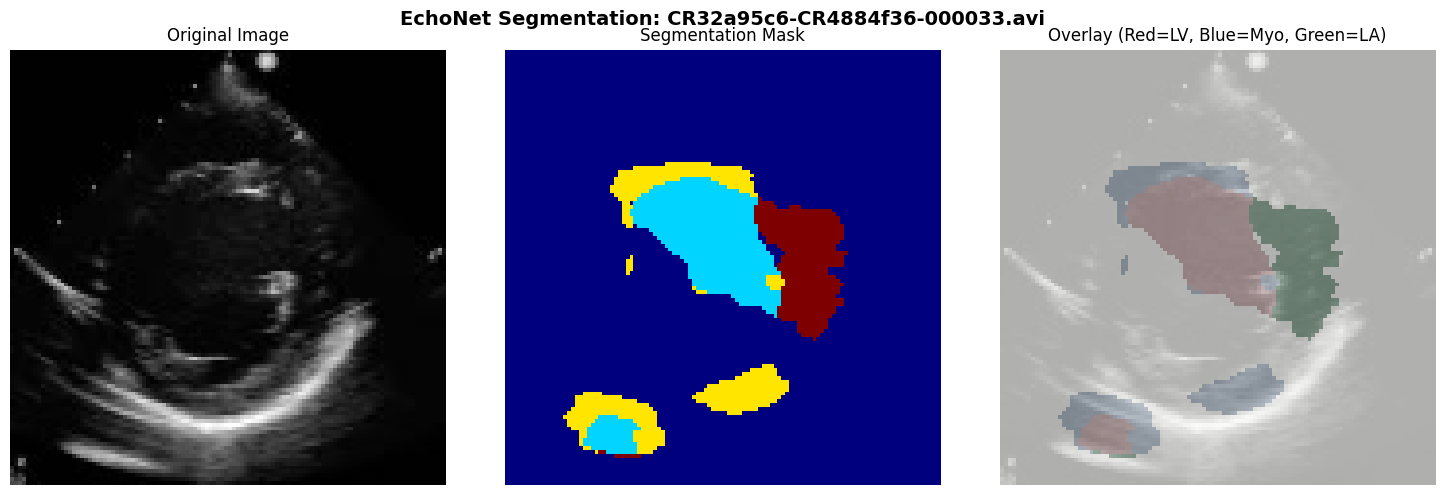

In [11]:
# Cell [11]
# ============================================================================
# EXAMPLE: Visualize Segmentation on EchoNet Frame
# ============================================================================

if DATASET_TYPE == "ECHONET" and seg_model is not None:
    video_folder = os.path.join(ECHONET_DIR, "Videos")
    if os.path.exists(video_folder):
        video_files = [os.path.join(video_folder, f)
                       for f in os.listdir(video_folder)
                       if f.endswith(('.avi', '.mp4'))]
        
        if video_files:
            # Take first video
            video_path = video_files[0]
            
            # Extract middle frame
            cap = cv2.VideoCapture(video_path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            cap.set(cv2.CAP_PROP_POS_FRAMES, total_frames // 2)
            ret, frame = cap.read()
            cap.release()
            
            if ret:
                frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                
                # Segment
                seg_tensor = preprocess_for_segmentation(frame_gray)
                pred_mask = segment_image(seg_model, seg_tensor)
                
                # Visualize
                visualize_segmentation_overlay(
                    frame_gray, 
                    pred_mask, 
                    title=f"EchoNet Segmentation: {os.path.basename(video_path)}"
                )

In [12]:
# Cell [12]
# ============================================================================
# EXAMPLE: Visualize Segmentation on Cactus Image
# ============================================================================

if DATASET_TYPE == "CACTUS" and seg_model is not None:
    image_dir = os.path.join(CACTUS_DIR, "Images Dataset", "A4C")
    if os.path.exists(image_dir):
        image_files = [os.path.join(image_dir, f)
                       for f in os.listdir(image_dir)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if image_files:
            # Take first image
            img_path = image_files[0]
            img = cv2.imread(img_path)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # Segment
            seg_tensor = preprocess_for_segmentation(img_gray)
            pred_mask = segment_image(seg_model, seg_tensor)
            
            # Visualize
            visualize_segmentation_overlay(
                img_gray, 
                pred_mask, 
                title=f"Cactus Segmentation: {os.path.basename(img_path)}"
            )

In [13]:
# Cell [13]
# ============================================================================
# EXAMPLE: Visualize Segmentation on CAMUS Image
# ============================================================================

if DATASET_TYPE == "CAMUS" and seg_model is not None:
    patients = explore_camus(CAMUS_DIR)
    if patients:
        pid = patients[0]
        img = load_image(pid, "4CH", "ED", CAMUS_DIR)
        
        if img is not None:
            # Segment
            seg_tensor = preprocess_for_segmentation(img)
            pred_mask = segment_image(seg_model, seg_tensor)
            
            # Visualize
            visualize_segmentation_overlay(
                img, 
                pred_mask, 
                title=f"CAMUS Segmentation: {pid} 4CH ED"
            )

In [14]:
# Cell [14]
# ============================================================================
# SUMMARY STATISTICS ACROSS ALL ANALYSES
# ============================================================================

def print_summary_statistics(results):
    """Print comprehensive summary of all analyses"""
    if not results:
        print("No results to summarize")
        return
    
    print("\n" + "="*70)
    print("📊 COMPREHENSIVE ANALYSIS SUMMARY")
    print("="*70 + "\n")
    
    dataset = results[0].get("dataset", "Unknown")
    print(f"Dataset: {dataset}")
    print(f"Total analyzed: {len(results)}")
    
    # Quality statistics
    quality_results = [r.get("quality") for r in results if r.get("quality")]
    if quality_results:
        print("\n⭐ QUALITY ASSESSMENT SUMMARY:")
        grades = [q["grade"] for q in quality_results]
        qualities = [q["quality"] for q in quality_results]
        confidences = [q["confidence"] for q in quality_results]
        
        print(f"  Average Grade: {np.mean(grades):.1f}/10")
        print(f"  Grade Range: {np.min(grades)}-{np.max(grades)}")
        print(f"  Average Confidence: {np.mean(confidences):.2%}")
        
        quality_counts = pd.Series(qualities).value_counts()
        print(f"  Quality Distribution:")
        for quality, count in quality_counts.items():
            print(f"    {quality}: {count}")
    
    # Cardiac metrics statistics (CAMUS)
    if dataset == "CAMUS":
        ef_values = [r.get("EF") for r in results if r.get("EF")]
        edv_values = [r.get("EDV") for r in results if r.get("EDV")]
        esv_values = [r.get("ESV") for r in results if r.get("ESV")]
        
        if ef_values:
            print("\n💓 CARDIAC METRICS SUMMARY:")
            print(f"  EF:  {np.mean(ef_values):.1f} ± {np.std(ef_values):.1f}%")
            print(f"  EDV: {np.mean(edv_values):.1f} ± {np.std(edv_values):.1f} mL")
            print(f"  ESV: {np.mean(esv_values):.1f} ± {np.std(esv_values):.1f} mL")
    
    # EF prediction statistics (EchoNet)
    if dataset == "ECHONET":
        ef_values = [r.get("predicted_ef") for r in results if r.get("predicted_ef")]
        if ef_values:
            print("\n💓 EF PREDICTION SUMMARY:")
            print(f"  Mean Predicted EF: {np.mean(ef_values):.2f}%")
            print(f"  Std: {np.std(ef_values):.2f}%")
            print(f"  Range: {np.min(ef_values):.2f}% - {np.max(ef_values):.2f}%")
    
    # Segmentation statistics
    seg_results = [r.get("segmentation") for r in results if r.get("segmentation")]
    if seg_results:
        print("\n🔍 SEGMENTATION SUMMARY:")
        lv_areas = [s["lv_area_mm2"] for s in seg_results]
        lv_lengths = [s["lv_length_mm"] for s in seg_results]
        print(f"  Average LV Area: {np.mean(lv_areas):.1f} mm²")
        print(f"  Average LV Length: {np.mean(lv_lengths):.1f} mm")

if 'all_results' in locals() and all_results:
    print_summary_statistics(all_results)


📊 COMPREHENSIVE ANALYSIS SUMMARY

Dataset: ECHONET
Total analyzed: 3

⭐ QUALITY ASSESSMENT SUMMARY:
  Average Grade: 3.7/10
  Grade Range: 3-4
  Average Confidence: 64.42%
  Quality Distribution:
    Bad: 2
    Good: 1

💓 EF PREDICTION SUMMARY:
  Mean Predicted EF: 54.44%
  Std: 1.78%
  Range: 51.96% - 56.07%

🔍 SEGMENTATION SUMMARY:
  Average LV Area: 870.1 mm²
  Average LV Length: 72.0 mm


In [15]:
# Cell [15]
# ============================================================================
# EXPORT COMPREHENSIVE RESULTS TO CSV
# ============================================================================

def export_comprehensive_results(results, output_dir="results"):
    """Export all results to CSV with all metrics"""
    if not results:
        print("No results to export")
        return
    
    os.makedirs(output_dir, exist_ok=True)
    
    dataset = results[0].get("dataset", "Unknown")
    filename = f"{dataset.lower()}_comprehensive_results.csv"
    filepath = os.path.join(output_dir, filename)
    
    # Flatten nested dictionaries
    flat_results = []
    for r in results:
        flat_r = {}
        for key, value in r.items():
            if isinstance(value, dict):
                for sub_key, sub_value in value.items():
                    flat_r[f"{key}_{sub_key}"] = sub_value
            else:
                flat_r[key] = value
        flat_results.append(flat_r)
    
    df = pd.DataFrame(flat_results)
    df.to_csv(filepath, index=False)
    print(f"✅ Results exported to {filepath}")
    print(f"   Columns: {list(df.columns)}")
    print(f"   Rows: {len(df)}")
    
    return df

if 'all_results' in locals() and all_results:
    results_df = export_comprehensive_results(all_results)
    display(results_df.head())

✅ Results exported to results/echonet_comprehensive_results.csv
   Columns: ['video', 'video_path', 'dataset', 'total_frames', 'fps', 'predicted_ef', 'quality_grade', 'quality_quality', 'quality_confidence', 'segmentation_lv_area_mm2', 'segmentation_lv_length_mm', 'segmentation_lv_pixels', 'segmentation']
   Rows: 3


,video,video_path,dataset,total_frames,fps,predicted_ef,quality_grade,quality_quality,quality_confidence,segmentation_lv_area_mm2,segmentation_lv_length_mm,segmentation_lv_pixels,segmentation
0,CR32a95c6-CR4884f36-000033.avi,/home/users/joshua04/141/data/raw/echonet_pedi...,ECHONET,99,68.0,51.963879,3,Bad,0.707938,1170.75,99.624294,4683.0,NaN
1,CR32a95d2-CR3dcb631-000031.avi,/home/users/joshua04/141/data/raw/echonet_pedi...,ECHONET,401,73.0,55.272068,4,Bad,0.677270,569.50,44.432533,2278.0,NaN
2,CR3dcb0e4-CR3dcb2a4-000024.avi,/home/users/joshua04/141/data/raw/echonet_pedi...,ECHONET,77,50.0,56.071777,4,Good,0.547399,NaN,NaN,NaN,NaN


In [16]:
# Cell [16]
# ============================================================================
# COMPREHENSIVE REPORT GENERATION
# ============================================================================

def generate_comprehensive_report():
    """Generate detailed report of all capabilities"""
    print("\n" + "="*70)
    print("📋 COMPREHENSIVE CARDIAC ULTRASOUND ANALYSIS REPORT")
    print("="*70 + "\n")
    
    print(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Device: {DEVICE}\n")
    
    print("="*70)
    print("MODEL CAPABILITIES")
    print("="*70)
    
    print("\n1️⃣  U-Net Segmentation Model:")
    print(f"    Status: {'✅ Loaded' if seg_model else '❌ Not Available'}")
    print(f"    Trained on: CAMUS dataset")
    print(f"    Output: 4-class segmentation (Background, LV, Myocardium, LA)")
    print(f"    Can process: CAMUS, Cactus images, EchoNet video frames")
    
    print("\n2️⃣  Cactus Quality Assessment Model:")
    print(f"    Status: {'✅ Loaded' if cactus_model else '❌ Not Available'}")
    print(f"    Trained on: Cactus dataset")
    print(f"    Output: Quality grade (1-10) + classification (Bad/Okay/Good)")
    print(f"    Can process: CAMUS images, Cactus images, EchoNet video frames")
    
    print("\n3️⃣  EchoNet EF Prediction Model:")
    print(f"    Status: {'✅ Loaded' if ef_model else '❌ Not Available'}")
    print(f"    Trained on: EchoNet Pediatric dataset")
    print(f"    Output: Ejection Fraction (EF) prediction")
    print(f"    Can process: EchoNet videos (.avi and .mp4)")
    
    print("\n" + "="*70)
    print("DATASET ANALYSIS CAPABILITIES")
    print("="*70)
    
    print("\n📊 CAMUS Dataset:")
    print(f"    Available: {'✅' if os.path.exists(CAMUS_DIR) else '❌'}")
    print(f"    Ground Truth Metrics: ✅ (EDV, ESV, SV, EF, CO)")
    print(f"    U-Net Segmentation: {'✅' if seg_model else '❌'}")
    print(f"    Quality Assessment: {'✅' if cactus_model else '❌'}")
    print(f"    EF Prediction: ❌ (not video data)")
    
    print("\n📊 Cactus Dataset:")
    print(f"    Available: {'✅' if os.path.exists(CACTUS_DIR) else '❌'}")
    print(f"    Ground Truth Metrics: ❌")
    print(f"    U-Net Segmentation: {'✅ (cross-domain)' if seg_model else '❌'}")
    print(f"    Quality Assessment: {'✅' if cactus_model else '❌'}")
    print(f"    EF Prediction: ❌ (not video data)")
    
    print("\n📊 EchoNet Dataset:")
    video_folder = os.path.join(ECHONET_DIR, "Videos")
    has_videos = False
    if os.path.exists(video_folder):
        video_files = [f for f in os.listdir(video_folder) if f.endswith(('.avi', '.mp4'))]
        has_videos = len(video_files) > 0
    
    print(f"    Available: {'✅' if has_videos else '❌'}")
    print(f"    Ground Truth Metrics: ⚠️  (EF labels available)")
    print(f"    U-Net Segmentation: {'✅ (cross-domain, frame-level)' if seg_model else '❌'}")
    print(f"    Quality Assessment: {'✅ (frame-level)' if cactus_model else '❌'}")
    print(f"    EF Prediction: {'✅' if ef_model else '❌'}")
    
    print("\n" + "="*70)
    print("CURRENT CONFIGURATION")
    print("="*70)
    print(f"Selected Dataset: {DATASET_TYPE}")
    print(f"\nTo analyze different dataset, change DATASET_TYPE in Cell [2]")
    print(f"Then run Cell [9] for comprehensive analysis")

generate_comprehensive_report()


📋 COMPREHENSIVE CARDIAC ULTRASOUND ANALYSIS REPORT

Analysis Date: 2026-02-04 14:34:02
Device: cuda

MODEL CAPABILITIES

1️⃣  U-Net Segmentation Model:
    Status: ✅ Loaded
    Trained on: CAMUS dataset
    Output: 4-class segmentation (Background, LV, Myocardium, LA)
    Can process: CAMUS, Cactus images, EchoNet video frames

2️⃣  Cactus Quality Assessment Model:
    Status: ✅ Loaded
    Trained on: Cactus dataset
    Output: Quality grade (1-10) + classification (Bad/Okay/Good)
    Can process: CAMUS images, Cactus images, EchoNet video frames

3️⃣  EchoNet EF Prediction Model:
    Status: ✅ Loaded
    Trained on: EchoNet Pediatric dataset
    Output: Ejection Fraction (EF) prediction
    Can process: EchoNet videos (.avi and .mp4)

DATASET ANALYSIS CAPABILITIES

📊 CAMUS Dataset:
    Available: ✅
    Ground Truth Metrics: ✅ (EDV, ESV, SV, EF, CO)
    U-Net Segmentation: ✅
    Quality Assessment: ✅
    EF Prediction: ❌ (not video data)

📊 Cactus Dataset:
    Available: ✅
    Ground 

In [17]:
# Cell [17]
# ============================================================================
# VIEW ALL RESULTS IN A NICE TABLE
# ============================================================================

if 'all_results' in locals() and all_results:
    print("\n" + "="*70)
    print("📋 ALL RESULTS TABLE")
    print("="*70 + "\n")
    
    # Create a flattened version for easy viewing
    display_data = []
    
    for r in all_results:
        row = {}
        
        # Basic info
        if 'patient' in r:
            row['ID'] = r['patient']
        elif 'image' in r:
            row['ID'] = r['image']
        elif 'video' in r:
            row['ID'] = r['video']
        
        row['Dataset'] = r.get('dataset', 'N/A')
        
        # Cardiac metrics
        row['EDV (mL)'] = f"{r.get('EDV', 'N/A'):.1f}" if r.get('EDV') else 'N/A'
        row['ESV (mL)'] = f"{r.get('ESV', 'N/A'):.1f}" if r.get('ESV') else 'N/A'
        row['SV (mL)'] = f"{r.get('SV', 'N/A'):.1f}" if r.get('SV') else 'N/A'
        row['EF (%)'] = f"{r.get('EF', 'N/A'):.1f}" if r.get('EF') else 'N/A'
        
        # EF prediction
        row['Pred EF (%)'] = f"{r.get('predicted_ef', 'N/A'):.1f}" if r.get('predicted_ef') else 'N/A'
        
        # Quality
        if r.get('quality'):
            row['Quality'] = r['quality']['quality']
            row['Grade'] = f"{r['quality']['grade']}/10"
            row['Confidence'] = f"{r['quality']['confidence']:.1%}"
        else:
            row['Quality'] = 'N/A'
            row['Grade'] = 'N/A'
            row['Confidence'] = 'N/A'
        
        # Segmentation
        if r.get('segmentation'):
            row['LV Area (mm²)'] = f"{r['segmentation']['lv_area_mm2']:.1f}"
            row['LV Length (mm)'] = f"{r['segmentation']['lv_length_mm']:.1f}"
        else:
            row['LV Area (mm²)'] = 'N/A'
            row['LV Length (mm)'] = 'N/A'
        
        display_data.append(row)
    
    # Create DataFrame and display
    df = pd.DataFrame(display_data)
    display(df)
    
    print(f"\n✅ Displayed {len(df)} results")
else:
    print("❌ No results available. Run Cell [9] first!")


📋 ALL RESULTS TABLE



,ID,Dataset,EDV (mL),ESV (mL),SV (mL),EF (%),Pred EF (%),Quality,Grade,Confidence,LV Area (mm²),LV Length (mm)
0,CR32a95c6-CR4884f36-000033.avi,ECHONET,N/A,N/A,N/A,N/A,52.0,Bad,3/10,70.8%,1170.8,99.6
1,CR32a95d2-CR3dcb631-000031.avi,ECHONET,N/A,N/A,N/A,N/A,55.3,Bad,4/10,67.7%,569.5,44.4
2,CR3dcb0e4-CR3dcb2a4-000024.avi,ECHONET,N/A,N/A,N/A,N/A,56.1,Good,4/10,54.7%,N/A,N/A



✅ Displayed 3 results



Segmentation for CR32a95c6-CR4884f36-000033.avi


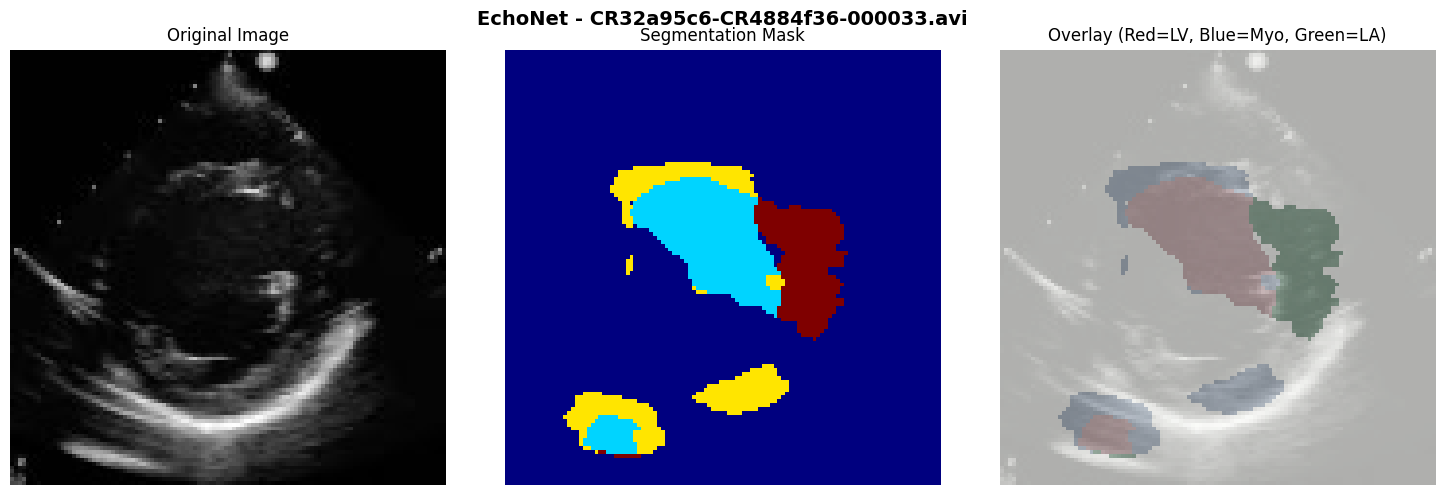


Segmentation for CR32a95d2-CR3dcb631-000031.avi


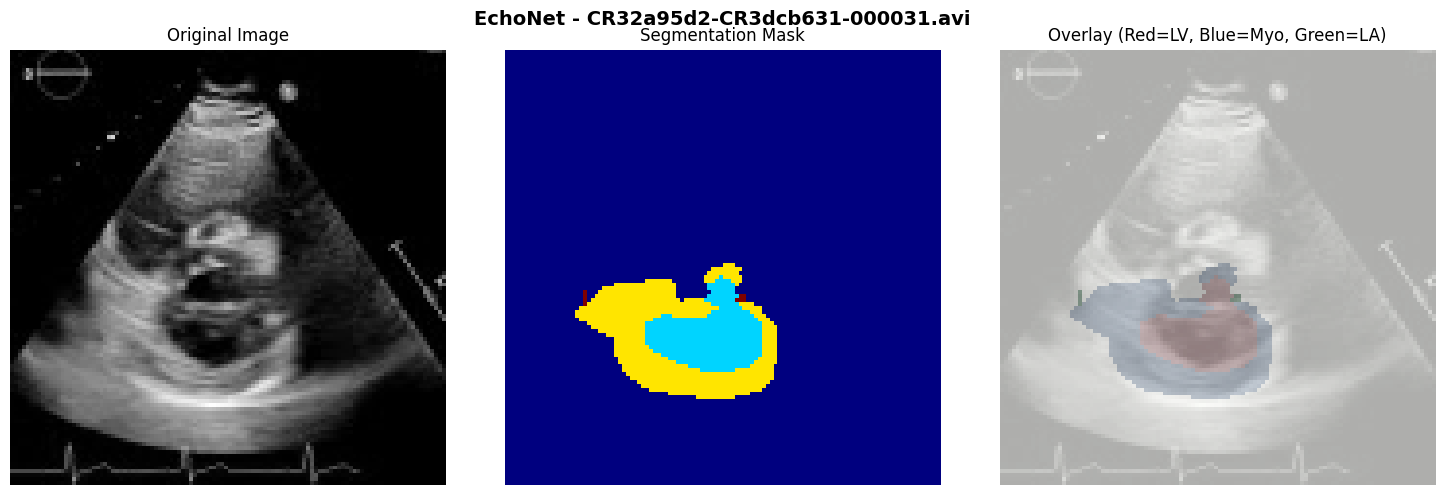


Segmentation for CR3dcb0e4-CR3dcb2a4-000024.avi


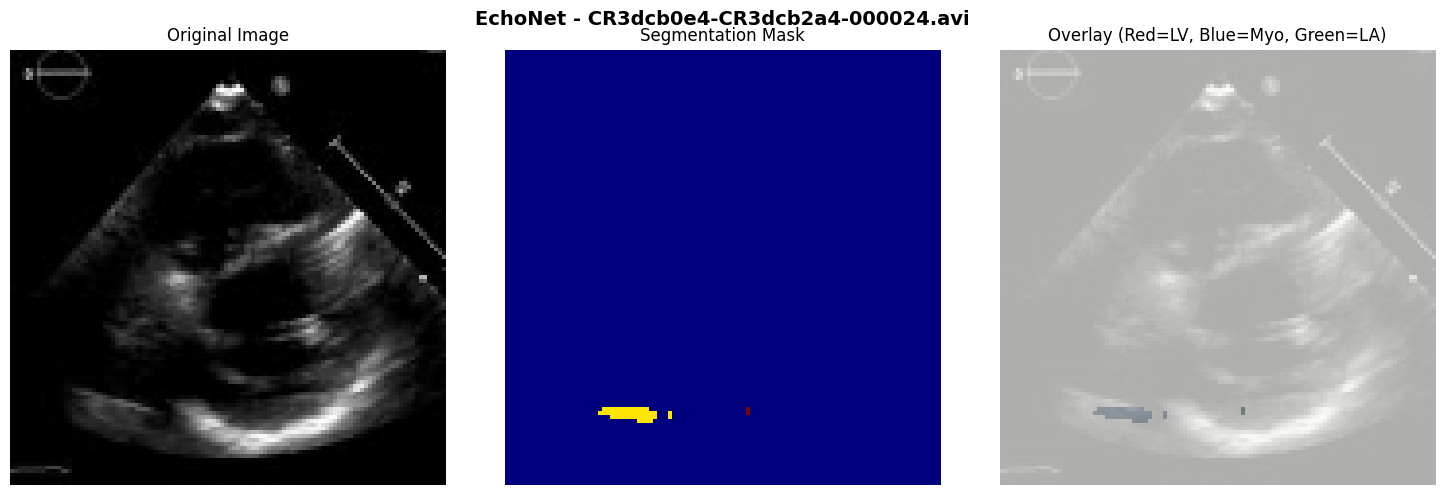

In [18]:
# Cell [18]
# ============================================================================
# VISUALIZE SEGMENTATION FOR ALL ANALYZED SAMPLES
# ============================================================================

def show_all_segmentations():
    """Show segmentation overlays for all analyzed samples"""
    
    if DATASET_TYPE == "CAMUS":
        patients = explore_camus(CAMUS_DIR)
        if not patients or seg_model is None:
            print("❌ Cannot visualize - data or model not available")
            return
        
        for pid in patients[:3]:  # Show first 3
            print(f"\n{'='*70}")
            print(f"Segmentation for {pid}")
            print(f"{'='*70}")
            
            img = load_image(pid, "4CH", "ED", CAMUS_DIR)
            if img is not None:
                seg_tensor = preprocess_for_segmentation(img)
                pred_mask = segment_image(seg_model, seg_tensor)
                visualize_segmentation_overlay(img, pred_mask, title=f"{pid} - 4CH ED")
    
    elif DATASET_TYPE == "CACTUS":
        image_dir = os.path.join(CACTUS_DIR, "Images Dataset", "A4C")
        if not os.path.exists(image_dir) or seg_model is None:
            print("❌ Cannot visualize - data or model not available")
            return
        
        image_files = [os.path.join(image_dir, f)
                       for f in os.listdir(image_dir)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:3]
        
        for img_path in image_files:
            print(f"\n{'='*70}")
            print(f"Segmentation for {os.path.basename(img_path)}")
            print(f"{'='*70}")
            
            img = cv2.imread(img_path)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            seg_tensor = preprocess_for_segmentation(img_gray)
            pred_mask = segment_image(seg_model, seg_tensor)
            visualize_segmentation_overlay(img_gray, pred_mask, 
                                          title=f"Cactus - {os.path.basename(img_path)}")
    
    elif DATASET_TYPE == "ECHONET":
        video_folder = os.path.join(ECHONET_DIR, "Videos")
        if not os.path.exists(video_folder) or seg_model is None:
            print("❌ Cannot visualize - data or model not available")
            return
        
        video_files = [os.path.join(video_folder, f)
                       for f in os.listdir(video_folder)
                       if f.endswith(('.avi', '.mp4'))][:3]
        
        for video_path in video_files:
            print(f"\n{'='*70}")
            print(f"Segmentation for {os.path.basename(video_path)}")
            print(f"{'='*70}")
            
            cap = cv2.VideoCapture(video_path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            cap.set(cv2.CAP_PROP_POS_FRAMES, total_frames // 2)
            ret, frame = cap.read()
            cap.release()
            
            if ret:
                frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                seg_tensor = preprocess_for_segmentation(frame_gray)
                pred_mask = segment_image(seg_model, seg_tensor)
                visualize_segmentation_overlay(frame_gray, pred_mask, 
                                              title=f"EchoNet - {os.path.basename(video_path)}")

# Run visualization
show_all_segmentations()

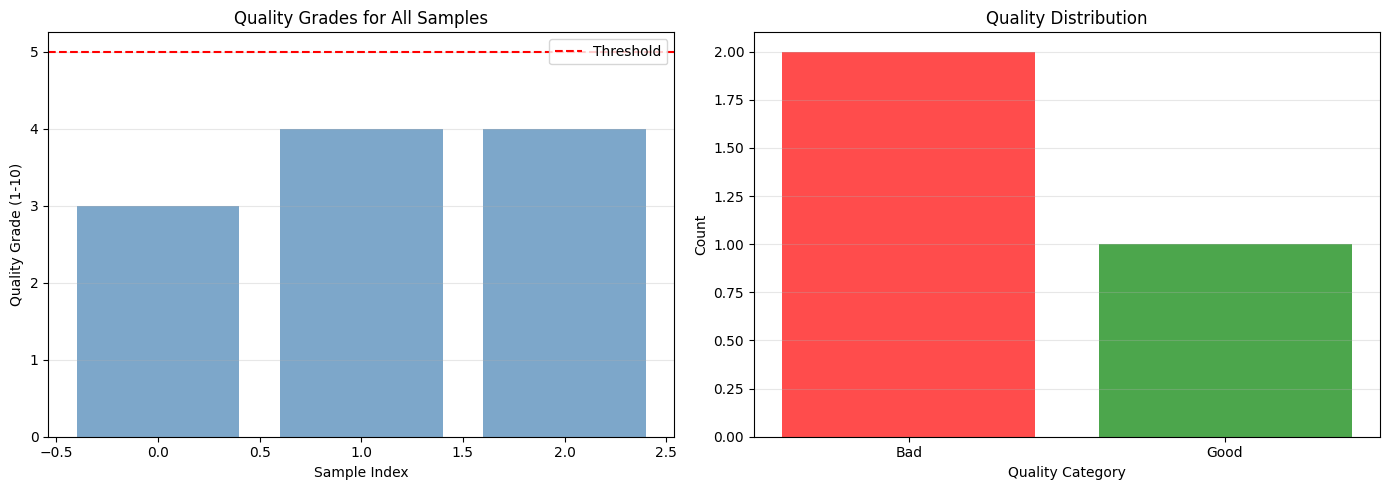


📊 Quality Summary:
  Average Grade: 3.7/10
  Grade Range: 3-4
  Bad: 2 samples
  Good: 1 samples


In [19]:
# Cell [19]
# ============================================================================
# PLOT QUALITY GRADES AS BAR CHART
# ============================================================================

if 'all_results' in locals() and all_results:
    quality_results = [r.get("quality") for r in all_results if r.get("quality")]
    
    if quality_results:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Grade distribution
        grades = [q["grade"] for q in quality_results]
        qualities = [q["quality"] for q in quality_results]
        
        axes[0].bar(range(len(grades)), grades, color='steelblue', alpha=0.7)
        axes[0].axhline(y=5, color='red', linestyle='--', label='Threshold')
        axes[0].set_xlabel('Sample Index')
        axes[0].set_ylabel('Quality Grade (1-10)')
        axes[0].set_title('Quality Grades for All Samples')
        axes[0].legend()
        axes[0].grid(axis='y', alpha=0.3)
        
        # Quality distribution
        quality_counts = pd.Series(qualities).value_counts()
        colors = {'Bad': 'red', 'Okay': 'orange', 'Good': 'green'}
        bar_colors = [colors.get(q, 'gray') for q in quality_counts.index]
        
        axes[1].bar(quality_counts.index, quality_counts.values, color=bar_colors, alpha=0.7)
        axes[1].set_xlabel('Quality Category')
        axes[1].set_ylabel('Count')
        axes[1].set_title('Quality Distribution')
        axes[1].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n📊 Quality Summary:")
        print(f"  Average Grade: {np.mean(grades):.1f}/10")
        print(f"  Grade Range: {min(grades)}-{max(grades)}")
        for quality, count in quality_counts.items():
            print(f"  {quality}: {count} samples")
    else:
        print("❌ No quality results to plot")
else:
    print("❌ No results available. Run Cell [9] first!")

In [20]:
# Cell [20]
# ============================================================================
# PLOT CARDIAC METRICS (FOR CAMUS)
# ============================================================================

if DATASET_TYPE == "CAMUS" and 'all_results' in locals() and all_results:
    # Extract metrics
    patients = [r['patient'] for r in all_results if 'patient' in r]
    edv_values = [r.get('EDV') for r in all_results if r.get('EDV')]
    esv_values = [r.get('ESV') for r in all_results if r.get('ESV')]
    sv_values = [r.get('SV') for r in all_results if r.get('SV')]
    ef_values = [r.get('EF') for r in all_results if r.get('EF')]
    
    if edv_values:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # EDV
        axes[0, 0].bar(range(len(edv_values)), edv_values, color='steelblue', alpha=0.7)
        axes[0, 0].set_title('End-Diastolic Volume (EDV)', fontweight='bold')
        axes[0, 0].set_ylabel('Volume (mL)')
        axes[0, 0].set_xlabel('Patient Index')
        axes[0, 0].grid(axis='y', alpha=0.3)
        
        # ESV
        axes[0, 1].bar(range(len(esv_values)), esv_values, color='coral', alpha=0.7)
        axes[0, 1].set_title('End-Systolic Volume (ESV)', fontweight='bold')
        axes[0, 1].set_ylabel('Volume (mL)')
        axes[0, 1].set_xlabel('Patient Index')
        axes[0, 1].grid(axis='y', alpha=0.3)
        
        # SV
        axes[1, 0].bar(range(len(sv_values)), sv_values, color='mediumseagreen', alpha=0.7)
        axes[1, 0].set_title('Stroke Volume (SV)', fontweight='bold')
        axes[1, 0].set_ylabel('Volume (mL)')
        axes[1, 0].set_xlabel('Patient Index')
        axes[1, 0].grid(axis='y', alpha=0.3)
        
        # EF
        axes[1, 1].bar(range(len(ef_values)), ef_values, color='mediumpurple', alpha=0.7)
        axes[1, 1].axhline(y=50, color='red', linestyle='--', label='Normal threshold')
        axes[1, 1].set_title('Ejection Fraction (EF)', fontweight='bold')
        axes[1, 1].set_ylabel('EF (%)')
        axes[1, 1].set_xlabel('Patient Index')
        axes[1, 1].legend()
        axes[1, 1].grid(axis='y', alpha=0.3)
        
        plt.suptitle('Cardiac Functional Metrics', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print(f"\n📊 Cardiac Metrics Summary:")
        print(f"  EDV: {np.mean(edv_values):.1f} ± {np.std(edv_values):.1f} mL")
        print(f"  ESV: {np.mean(esv_values):.1f} ± {np.std(esv_values):.1f} mL")
        print(f"  SV:  {np.mean(sv_values):.1f} ± {np.std(sv_values):.1f} mL")
        print(f"  EF:  {np.mean(ef_values):.1f} ± {np.std(ef_values):.1f}%")

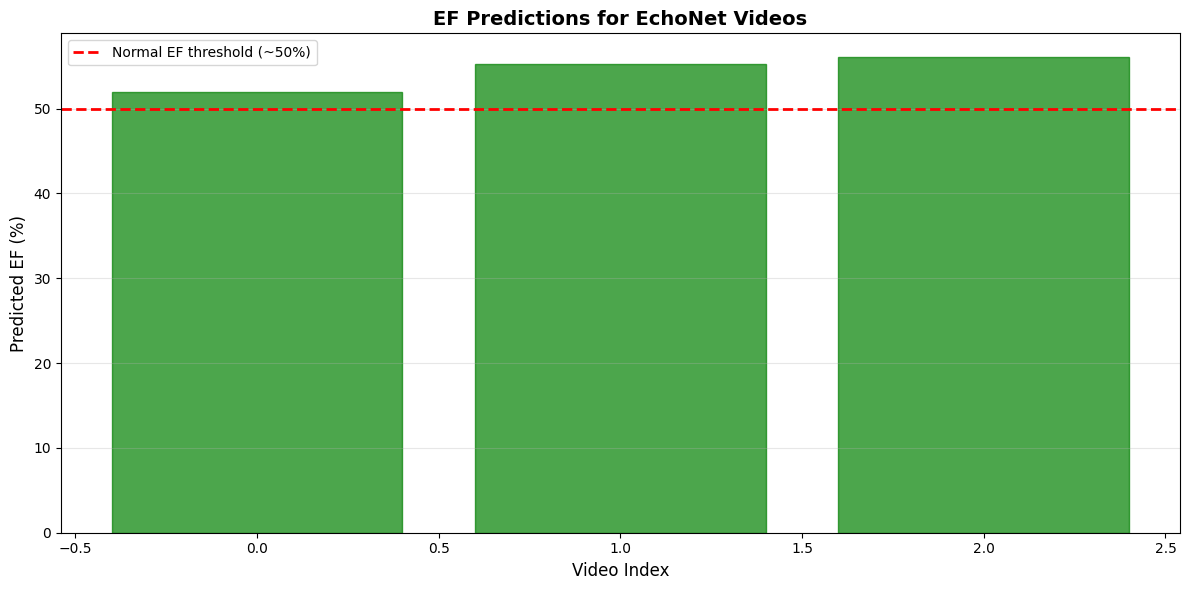


💓 EF Prediction Summary:
  Mean: 54.44%
  Std:  1.78%
  Min:  51.96%
  Max:  56.07%

  Abnormal (EF < 40%): 0
  Borderline (40% ≤ EF < 50%): 0
  Normal (EF ≥ 50%): 3


In [21]:
# Cell [21]
# ============================================================================
# PLOT EF PREDICTIONS (FOR ECHONET)
# ============================================================================

if DATASET_TYPE == "ECHONET" and 'all_results' in locals() and all_results:
    ef_predictions = [r.get('predicted_ef') for r in all_results if r.get('predicted_ef')]
    video_names = [r.get('video', f'Video {i}') for i, r in enumerate(all_results) if r.get('predicted_ef')]
    
    if ef_predictions:
        fig, ax = plt.subplots(figsize=(12, 6))
        
        bars = ax.bar(range(len(ef_predictions)), ef_predictions, color='mediumpurple', alpha=0.7)
        ax.axhline(y=50, color='red', linestyle='--', label='Normal EF threshold (~50%)', linewidth=2)
        ax.set_xlabel('Video Index', fontsize=12)
        ax.set_ylabel('Predicted EF (%)', fontsize=12)
        ax.set_title('EF Predictions for EchoNet Videos', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        
        # Color code bars
        for i, (bar, ef) in enumerate(zip(bars, ef_predictions)):
            if ef < 40:
                bar.set_color('red')
            elif ef < 50:
                bar.set_color('orange')
            else:
                bar.set_color('green')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n💓 EF Prediction Summary:")
        print(f"  Mean: {np.mean(ef_predictions):.2f}%")
        print(f"  Std:  {np.std(ef_predictions):.2f}%")
        print(f"  Min:  {np.min(ef_predictions):.2f}%")
        print(f"  Max:  {np.max(ef_predictions):.2f}%")
        print(f"\n  Abnormal (EF < 40%): {sum(1 for ef in ef_predictions if ef < 40)}")
        print(f"  Borderline (40% ≤ EF < 50%): {sum(1 for ef in ef_predictions if 40 <= ef < 50)}")
        print(f"  Normal (EF ≥ 50%): {sum(1 for ef in ef_predictions if ef >= 50)}")

Showing comprehensive analysis for first sample:


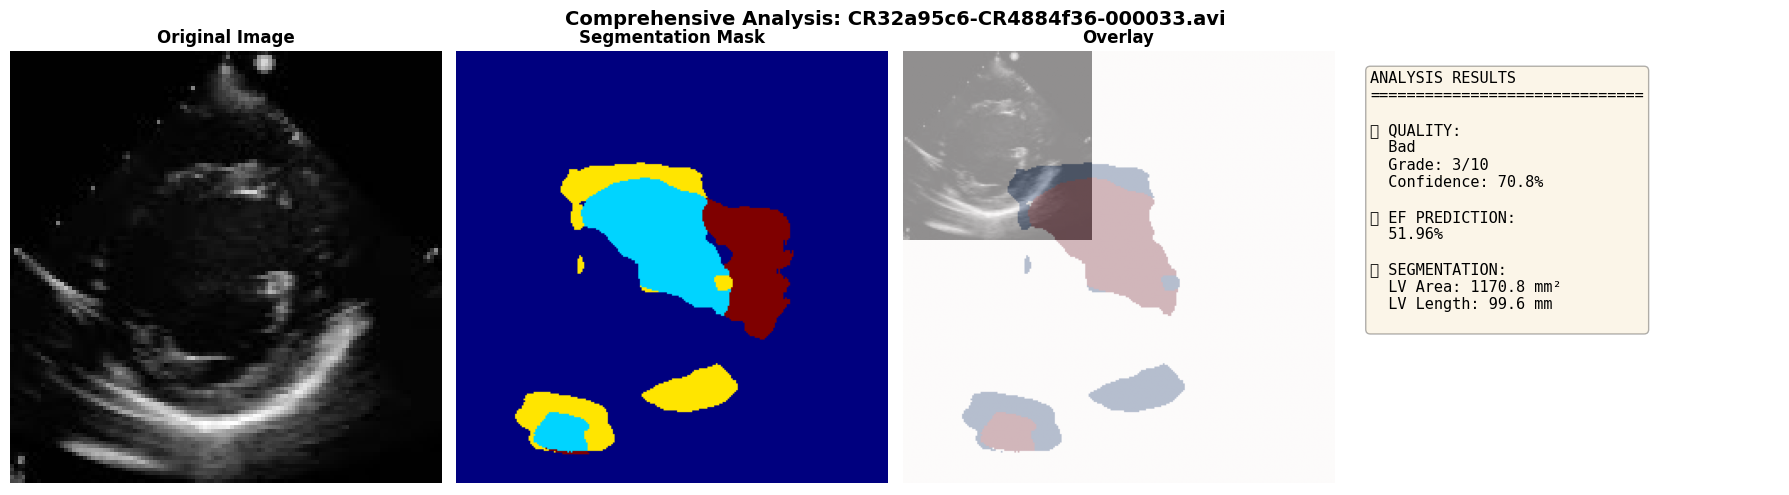


💡 TIP: Change sample_idx to see other samples:
   comprehensive_visualization(sample_idx=1)
   comprehensive_visualization(sample_idx=2)


In [22]:
# Cell [22]
# ============================================================================
# SIDE-BY-SIDE COMPARISON: Original vs Segmentation vs Quality
# ============================================================================

def comprehensive_visualization(sample_idx=0):
    """Show original image, segmentation, and quality assessment side by side"""
    
    if not all_results or sample_idx >= len(all_results):
        print("❌ Invalid sample index")
        return
    
    result = all_results[sample_idx]
    
    # Get image based on dataset type
    if DATASET_TYPE == "CAMUS":
        pid = result['patient']
        img = load_image(pid, "4CH", "ED", CAMUS_DIR)
        title = f"{pid} - 4CH ED"
    elif DATASET_TYPE == "CACTUS":
        img_name = result['image']
        img_path = os.path.join(CACTUS_DIR, "Images Dataset", "A4C", img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        title = img_name
    elif DATASET_TYPE == "ECHONET":
        video_name = result['video']
        video_path = os.path.join(ECHONET_DIR, "Videos", video_name)
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.set(cv2.CAP_PROP_POS_FRAMES, total_frames // 2)
        ret, frame = cap.read()
        cap.release()
        if ret:
            img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        else:
            img = None
        title = video_name
    
    if img is None:
        print("❌ Could not load image")
        return
    
    # Create figure
    fig = plt.figure(figsize=(18, 5))
    
    # Original image
    ax1 = plt.subplot(1, 4, 1)
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Original Image', fontweight='bold')
    ax1.axis('off')
    
    # Segmentation
    if seg_model is not None:
        ax2 = plt.subplot(1, 4, 2)
        seg_tensor = preprocess_for_segmentation(img)
        pred_mask = segment_image(seg_model, seg_tensor)
        ax2.imshow(pred_mask, cmap='jet')
        ax2.set_title('Segmentation Mask', fontweight='bold')
        ax2.axis('off')
        
        # Overlay
        ax3 = plt.subplot(1, 4, 3)
        ax3.imshow(img, cmap='gray')
        lv_mask = (pred_mask == 1).astype(float)
        myo_mask = (pred_mask == 2).astype(float)
        ax3.imshow(lv_mask, alpha=0.4, cmap='Reds')
        ax3.imshow(myo_mask, alpha=0.3, cmap='Blues')
        ax3.set_title('Overlay', fontweight='bold')
        ax3.axis('off')
    
    # Info panel
    ax4 = plt.subplot(1, 4, 4)
    ax4.axis('off')
    
    info_text = f"ANALYSIS RESULTS\n{'='*30}\n\n"
    
    # Quality
    if result.get('quality'):
        q = result['quality']
        info_text += f"⭐ QUALITY:\n"
        info_text += f"  {q['quality']}\n"
        info_text += f"  Grade: {q['grade']}/10\n"
        info_text += f"  Confidence: {q['confidence']:.1%}\n\n"
    
    # Cardiac metrics
    if result.get('EF'):
        info_text += f"💓 CARDIAC METRICS:\n"
        info_text += f"  EDV: {result['EDV']:.1f} mL\n"
        info_text += f"  ESV: {result['ESV']:.1f} mL\n"
        info_text += f"  SV: {result['SV']:.1f} mL\n"
        info_text += f"  EF: {result['EF']:.1f}%\n\n"
    
    # EF prediction
    if result.get('predicted_ef'):
        info_text += f"💓 EF PREDICTION:\n"
        info_text += f"  {result['predicted_ef']:.2f}%\n\n"
    
    # Segmentation metrics
    if result.get('segmentation'):
        s = result['segmentation']
        info_text += f"🔍 SEGMENTATION:\n"
        info_text += f"  LV Area: {s['lv_area_mm2']:.1f} mm²\n"
        info_text += f"  LV Length: {s['lv_length_mm']:.1f} mm\n"
    
    ax4.text(0.05, 0.95, info_text, transform=ax4.transAxes,
             fontsize=11, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.suptitle(f"Comprehensive Analysis: {title}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Show comprehensive view for first sample
if 'all_results' in locals() and all_results:
    print("Showing comprehensive analysis for first sample:")
    comprehensive_visualization(sample_idx=0)
    
    print("\n💡 TIP: Change sample_idx to see other samples:")
    print("   comprehensive_visualization(sample_idx=1)")
    print("   comprehensive_visualization(sample_idx=2)")

In [23]:
# Cell [23]
# ============================================================================
# DETAILED RESULTS VIEW WITH QUALITY EMPHASIS
# ============================================================================

if 'all_results' in locals() and all_results:
    print("\n" + "="*70)
    print("📊 DETAILED ANALYSIS RESULTS")
    print("="*70 + "\n")
    
    for idx, result in enumerate(all_results):
        print(f"\n{'='*70}")
        
        # Get identifier
        if 'patient' in result:
            identifier = result['patient']
        elif 'image' in result:
            identifier = result['image']
        elif 'video' in result:
            identifier = result['video']
        else:
            identifier = f"Sample {idx}"
        
        print(f"Sample {idx + 1}: {identifier}")
        print(f"{'='*70}")
        
        # Quality Assessment (MAIN OUTPUT FOR CACTUS)
        if result.get('quality'):
            q = result['quality']
            quality_emoji = {"Bad": "❌", "Okay": "⚠️", "Good": "✅"}
            emoji = quality_emoji.get(q['quality'], "❓")
            
            print(f"\n⭐ IMAGE QUALITY ASSESSMENT:")
            print(f"   {emoji} Quality: {q['quality']}")
            print(f"   📊 Grade: {q['grade']}/10")
            print(f"   🎯 Confidence: {q['confidence']:.1%}")
        else:
            print(f"\n⭐ IMAGE QUALITY ASSESSMENT: Not available")
        
        # Cardiac Metrics (CAMUS only)
        if result.get('EF'):
            print(f"\n💓 CARDIAC METRICS:")
            print(f"   EDV: {result['EDV']:.1f} mL")
            print(f"   ESV: {result['ESV']:.1f} mL")
            print(f"   SV:  {result['SV']:.1f} mL")
            print(f"   EF:  {result['EF']:.1f}%")
        
        # EF Prediction (EchoNet only)
        if result.get('predicted_ef'):
            print(f"\n💓 EF PREDICTION:")
            print(f"   Predicted EF: {result['predicted_ef']:.2f}%")
        
        # Segmentation Metrics (all datasets, but approximate for cross-domain)
        if result.get('segmentation'):
            s = result['segmentation']
            print(f"\n🔍 SEGMENTATION METRICS:")
            print(f"   LV Area: {s['lv_area_mm2']:.1f} mm²")
            print(f"   LV Length: {s['lv_length_mm']:.1f} mm")
            if result['dataset'] != 'CAMUS':
                print(f"   ⚠️  Note: Cross-domain transfer (trained on CAMUS)")
        
        print()
    
    print("="*70)
    print(f"✅ Displayed {len(all_results)} complete analyses")
    print("="*70)
else:
    print("❌ No results available. Run Cell [9] first!")


📊 DETAILED ANALYSIS RESULTS


Sample 1: CR32a95c6-CR4884f36-000033.avi

⭐ IMAGE QUALITY ASSESSMENT:
   ❌ Quality: Bad
   📊 Grade: 3/10
   🎯 Confidence: 70.8%

💓 EF PREDICTION:
   Predicted EF: 51.96%

🔍 SEGMENTATION METRICS:
   LV Area: 1170.8 mm²
   LV Length: 99.6 mm
   ⚠️  Note: Cross-domain transfer (trained on CAMUS)


Sample 2: CR32a95d2-CR3dcb631-000031.avi

⭐ IMAGE QUALITY ASSESSMENT:
   ❌ Quality: Bad
   📊 Grade: 4/10
   🎯 Confidence: 67.7%

💓 EF PREDICTION:
   Predicted EF: 55.27%

🔍 SEGMENTATION METRICS:
   LV Area: 569.5 mm²
   LV Length: 44.4 mm
   ⚠️  Note: Cross-domain transfer (trained on CAMUS)


Sample 3: CR3dcb0e4-CR3dcb2a4-000024.avi

⭐ IMAGE QUALITY ASSESSMENT:
   ✅ Quality: Good
   📊 Grade: 4/10
   🎯 Confidence: 54.7%

💓 EF PREDICTION:
   Predicted EF: 56.07%

✅ Displayed 3 complete analyses


In [24]:
# Cell [24]
# ============================================================================
# CACTUS QUALITY GRID VISUALIZATION
# ============================================================================

if DATASET_TYPE == "CACTUS" and 'all_results' in locals() and all_results:
    print("\n" + "="*70)
    print("🔍 CACTUS IMAGE QUALITY GRID")
    print("="*70 + "\n")
    
    image_dir = os.path.join(CACTUS_DIR, "Images Dataset", "A4C")
    
    # Create grid of images with quality labels
    n_samples = min(6, len(all_results))
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx in range(n_samples):
        result = all_results[idx]
        img_name = result['image']
        img_path = os.path.join(image_dir, img_name)
        
        # Load and display image
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(img_rgb)
        axes[idx].axis('off')
        
        # Create title with quality info
        if result.get('quality'):
            q = result['quality']
            quality_color = {"Bad": "red", "Okay": "orange", "Good": "green"}
            color = quality_color.get(q['quality'], "black")
            
            title = f"{q['quality']} (Grade: {q['grade']}/10)\nConfidence: {q['confidence']:.1%}"
            axes[idx].set_title(title, fontsize=11, fontweight='bold', color=color, pad=10)
        else:
            axes[idx].set_title(img_name, fontsize=10)
    
    # Hide extra subplots
    for idx in range(n_samples, 6):
        axes[idx].axis('off')
    
    plt.suptitle('CACTUS Image Quality Assessment Results', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n" + "="*70)
    print("📊 QUALITY SUMMARY")
    print("="*70)
    
    quality_results = [r['quality'] for r in all_results if r.get('quality')]
    if quality_results:
        grades = [q['grade'] for q in quality_results]
        qualities = [q['quality'] for q in quality_results]
        
        print(f"\nTotal Images Analyzed: {len(quality_results)}")
        print(f"Average Grade: {np.mean(grades):.1f}/10")
        print(f"Grade Range: {min(grades)} - {max(grades)}")
        print(f"\nQuality Distribution:")
        
        quality_counts = pd.Series(qualities).value_counts()
        for quality in ["Good", "Okay", "Bad"]:
            count = quality_counts.get(quality, 0)
            percentage = (count / len(qualities)) * 100
            emoji = {"Bad": "❌", "Okay": "⚠️", "Good": "✅"}[quality]
            print(f"  {emoji} {quality}: {count} images ({percentage:.1f}%)")

else:
    print("Set DATASET_TYPE to 'CACTUS' and run Cell [9] first!")

Set DATASET_TYPE to 'CACTUS' and run Cell [9] first!


In [25]:
# Cell [25]
# ============================================================================
# CARDIAC METRICS COMPARISON CHART
# ============================================================================

if DATASET_TYPE == "CAMUS" and 'all_results' in locals() and all_results:
    
    # Extract data
    patients = [r['patient'] for r in all_results]
    edv = [r['EDV'] for r in all_results]
    esv = [r['ESV'] for r in all_results]
    sv = [r['SV'] for r in all_results]
    ef = [r['EF'] for r in all_results]
    grades = [r['quality']['grade'] for r in all_results if r.get('quality')]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    x_pos = np.arange(len(patients))
    
    # EDV
    axes[0, 0].bar(x_pos, edv, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0, 0].set_title('End-Diastolic Volume (EDV)', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Volume (mL)', fontsize=12)
    axes[0, 0].set_xticks(x_pos)
    axes[0, 0].set_xticklabels([p.replace('patient', 'P') for p in patients], rotation=45)
    axes[0, 0].grid(axis='y', alpha=0.3)
    axes[0, 0].axhline(y=np.mean(edv), color='red', linestyle='--', label=f'Mean: {np.mean(edv):.1f}')
    axes[0, 0].legend()
    
    # ESV
    axes[0, 1].bar(x_pos, esv, color='coral', alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('End-Systolic Volume (ESV)', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Volume (mL)', fontsize=12)
    axes[0, 1].set_xticks(x_pos)
    axes[0, 1].set_xticklabels([p.replace('patient', 'P') for p in patients], rotation=45)
    axes[0, 1].grid(axis='y', alpha=0.3)
    axes[0, 1].axhline(y=np.mean(esv), color='red', linestyle='--', label=f'Mean: {np.mean(esv):.1f}')
    axes[0, 1].legend()
    
    # SV
    axes[0, 2].bar(x_pos, sv, color='mediumseagreen', alpha=0.7, edgecolor='black')
    axes[0, 2].set_title('Stroke Volume (SV)', fontsize=14, fontweight='bold')
    axes[0, 2].set_ylabel('Volume (mL)', fontsize=12)
    axes[0, 2].set_xticks(x_pos)
    axes[0, 2].set_xticklabels([p.replace('patient', 'P') for p in patients], rotation=45)
    axes[0, 2].grid(axis='y', alpha=0.3)
    axes[0, 2].axhline(y=np.mean(sv), color='red', linestyle='--', label=f'Mean: {np.mean(sv):.1f}')
    axes[0, 2].legend()
    
    # EF with color coding
    ef_colors = ['green' if e >= 55 else 'orange' if e >= 50 else 'red' for e in ef]
    axes[1, 0].bar(x_pos, ef, color=ef_colors, alpha=0.7, edgecolor='black')
    axes[1, 0].axhline(y=55, color='green', linestyle='--', linewidth=2, label='Normal (≥55%)')
    axes[1, 0].axhline(y=50, color='orange', linestyle='--', linewidth=2, label='Borderline (50%)')
    axes[1, 0].set_title('Ejection Fraction (EF)', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('EF (%)', fontsize=12)
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels([p.replace('patient', 'P') for p in patients], rotation=45)
    axes[1, 0].grid(axis='y', alpha=0.3)
    axes[1, 0].legend()
    
    # Quality Grades
    axes[1, 1].bar(x_pos, grades, color='mediumpurple', alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Image Quality Grade', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Grade (1-10)', fontsize=12)
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels([p.replace('patient', 'P') for p in patients], rotation=45)
    axes[1, 1].set_ylim(0, 10)
    axes[1, 1].grid(axis='y', alpha=0.3)
    axes[1, 1].axhline(y=np.mean(grades), color='red', linestyle='--', label=f'Mean: {np.mean(grades):.1f}')
    axes[1, 1].legend()
    
    # Summary Statistics Table
    axes[1, 2].axis('off')
    summary_text = f"""
    📊 SUMMARY STATISTICS
    {'='*35}
    
    Cardiac Metrics:
      EDV: {np.mean(edv):.1f} ± {np.std(edv):.1f} mL
      ESV: {np.mean(esv):.1f} ± {np.std(esv):.1f} mL
      SV:  {np.mean(sv):.1f} ± {np.std(sv):.1f} mL
      EF:  {np.mean(ef):.1f} ± {np.std(ef):.1f} %
    
    Quality Assessment:
      Avg Grade: {np.mean(grades):.1f}/10
      Range: {min(grades)}-{max(grades)}
    
    Clinical Interpretation:
      Normal EF: {sum(1 for e in ef if e >= 55)}/{len(ef)}
      Borderline: {sum(1 for e in ef if 50 <= e < 55)}/{len(ef)}
      Reduced: {sum(1 for e in ef if e < 50)}/{len(ef)}
    """
    
    axes[1, 2].text(0.1, 0.9, summary_text, transform=axes[1, 2].transAxes,
                    fontsize=12, verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle('Comprehensive Cardiac Analysis Dashboard', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("✅ Dashboard generated successfully!")

In [26]:
# Cell [26]
# ============================================================================
# EXPORT ALL RESULTS TO CSV
# ============================================================================

if 'all_results' in locals() and all_results:
    
    # Flatten results for CSV export
    export_data = []
    for r in all_results:
        row = {}
        
        # Basic info
        if 'patient' in r:
            row['ID'] = r['patient']
        elif 'image' in r:
            row['ID'] = r['image']
        elif 'video' in r:
            row['ID'] = r['video']
        
        row['Dataset'] = r.get('dataset', 'Unknown')
        
        # Cardiac metrics
        row['EDV_mL'] = r.get('EDV', None)
        row['ESV_mL'] = r.get('ESV', None)
        row['SV_mL'] = r.get('SV', None)
        row['EF_percent'] = r.get('EF', None)
        
        # Calculate CO if available
        if r.get('SV'):
            row['CO_L_min_at_75bpm'] = (r['SV'] * 75) / 1000
        else:
            row['CO_L_min_at_75bpm'] = None
        
        # Quality
        if r.get('quality'):
            row['Quality_Label'] = r['quality']['quality']
            row['Quality_Grade'] = r['quality']['grade']
            row['Quality_Confidence'] = r['quality']['confidence']
        else:
            row['Quality_Label'] = None
            row['Quality_Grade'] = None
            row['Quality_Confidence'] = None
        
        # Segmentation
        if r.get('segmentation'):
            row['LV_Area_mm2'] = r['segmentation']['lv_area_mm2']
            row['LV_Length_mm'] = r['segmentation']['lv_length_mm']
            row['LV_Pixels'] = r['segmentation']['lv_pixels']
        else:
            row['LV_Area_mm2'] = None
            row['LV_Length_mm'] = None
            row['LV_Pixels'] = None
        
        # EF prediction
        row['Predicted_EF_percent'] = r.get('predicted_ef', None)
        
        export_data.append(row)
    
    # Create DataFrame and save
    df = pd.DataFrame(export_data)
    
    # Create results directory
    os.makedirs('results', exist_ok=True)
    
    filename = f"results/{DATASET_TYPE.lower()}_comprehensive_analysis.csv"
    df.to_csv(filename, index=False)
    
    print("="*70)
    print(f"✅ Results exported to: {filename}")
    print("="*70)
    print(f"Total samples: {len(df)}")
    print(f"Columns: {len(df.columns)}")
    print(f"\nColumn names:")
    for col in df.columns:
        print(f"  - {col}")
    
    print("\n📊 Preview of exported data:")
    display(df)
    
else:
    print("❌ No results to export. Run Cell [9] first!")

✅ Results exported to: results/echonet_comprehensive_analysis.csv
Total samples: 3
Columns: 14

Column names:
  - ID
  - Dataset
  - EDV_mL
  - ESV_mL
  - SV_mL
  - EF_percent
  - CO_L_min_at_75bpm
  - Quality_Label
  - Quality_Grade
  - Quality_Confidence
  - LV_Area_mm2
  - LV_Length_mm
  - LV_Pixels
  - Predicted_EF_percent

📊 Preview of exported data:


,ID,Dataset,EDV_mL,ESV_mL,SV_mL,EF_percent,CO_L_min_at_75bpm,Quality_Label,Quality_Grade,Quality_Confidence,LV_Area_mm2,LV_Length_mm,LV_Pixels,Predicted_EF_percent
0,CR32a95c6-CR4884f36-000033.avi,ECHONET,None,None,None,None,None,Bad,3,0.707938,1170.75,99.624294,4683.0,51.963879
1,CR32a95d2-CR3dcb631-000031.avi,ECHONET,None,None,None,None,None,Bad,4,0.677270,569.50,44.432533,2278.0,55.272068
2,CR3dcb0e4-CR3dcb2a4-000024.avi,ECHONET,None,None,None,None,None,Good,4,0.547399,NaN,NaN,NaN,56.071777


In [27]:
# Cell [27]
# ============================================================================
# ENHANCED CARDIAC METRICS CALCULATION (from seg.py concepts)
# ============================================================================

def calculate_vti_from_geometry(lv_length_mm, lv_area_mm2):
    """
    Estimate VTI (Velocity Time Integral) from geometry
    VTI approximation based on LV outflow tract dimensions
    """
    # Approximate LVOT diameter from LV dimensions
    lvot_diameter_mm = lv_length_mm * 0.3  # Approximate ratio
    lvot_area_mm2 = np.pi * (lvot_diameter_mm / 2) ** 2
    
    # Estimate VTI (typical range 18-25 cm for normal)
    # This is a geometric approximation
    vti_cm = (lv_area_mm2 / lvot_area_mm2) * 2.0  # Simplified estimation
    
    return vti_cm, lvot_diameter_mm, lvot_area_mm2

def calculate_cardiac_index(co_L_min, bsa_m2):
    """Calculate Cardiac Index (CI) = CO / BSA"""
    return co_L_min / bsa_m2

def calculate_stroke_volume_index(sv_ml, bsa_m2):
    """Calculate Stroke Volume Index (SVI) = SV / BSA"""
    return sv_ml / bsa_m2

def estimate_bsa_dubois(weight_kg, height_cm):
    """
    Estimate Body Surface Area using DuBois formula
    BSA (m²) = 0.007184 × height^0.725 × weight^0.425
    """
    bsa = 0.007184 * (height_cm ** 0.725) * (weight_kg ** 0.425)
    return bsa

def calculate_comprehensive_cardiac_metrics(pid, data_dir=CAMUS_DIR, 
                                           hr_bpm=75, weight_kg=70, height_cm=170):
    """
    Calculate ALL cardiac metrics including advanced hemodynamics
    
    Parameters:
    - pid: patient ID
    - data_dir: dataset directory
    - hr_bpm: heart rate (beats per minute)
    - weight_kg: patient weight for BSA calculation
    - height_cm: patient height for BSA calculation
    
    Returns:
    - Dictionary with all cardiac metrics
    """
    
    # Basic volumes
    edv = lv_volume_ml(pid, "ED", data_dir)
    esv = lv_volume_ml(pid, "ES", data_dir)
    
    if None in [edv, esv]:
        return None
    
    # Basic calculations
    sv = edv - esv  # Stroke Volume
    ef = (sv / edv) * 100  # Ejection Fraction
    
    # Cardiac Output
    co = cardiac_output_L_min(sv, hr_bpm)
    
    # Get LV geometry for advanced metrics
    lv_area_ed = lv_area_mm2(pid, "4CH", "ED", data_dir)
    lv_length_ed = lv_length_mm(pid, "4CH", "ED", data_dir)
    
    # Calculate BSA
    bsa = estimate_bsa_dubois(weight_kg, height_cm)
    
    # Indexed metrics
    ci = calculate_cardiac_index(co, bsa)
    svi = calculate_stroke_volume_index(sv, bsa)
    edv_index = edv / bsa
    esv_index = esv / bsa
    
    # VTI estimation
    vti_cm = None
    lvot_diameter = None
    lvot_area = None
    if lv_area_ed and lv_length_ed:
        vti_cm, lvot_diameter, lvot_area = calculate_vti_from_geometry(lv_length_ed, lv_area_ed)
    
    # Mean Arterial Pressure (MAP) estimation
    # Assuming typical values - in practice, would measure
    systolic_bp = 120  # mmHg
    diastolic_bp = 80   # mmHg
    map_mmhg = diastolic_bp + (systolic_bp - diastolic_bp) / 3
    
    # Systemic Vascular Resistance (SVR)
    # SVR = (MAP - CVP) / CO × 80 (dynes·sec/cm⁵)
    # Assuming CVP (central venous pressure) = 8 mmHg
    cvp = 8
    svr = ((map_mmhg - cvp) / co) * 80
    
    # Return comprehensive metrics
    return {
        # Basic Volumes
        "EDV_mL": edv,
        "ESV_mL": esv,
        "SV_mL": sv,
        "EF_percent": ef,
        
        # Flow Metrics
        "CO_L_min": co,
        "HR_bpm": hr_bpm,
        "VTI_cm": vti_cm,
        
        # Indexed Metrics (normalized to body size)
        "BSA_m2": bsa,
        "CI_L_min_m2": ci,
        "SVI_mL_m2": svi,
        "EDVI_mL_m2": edv_index,
        "ESVI_mL_m2": esv_index,
        
        # Geometry
        "LV_Area_ED_mm2": lv_area_ed,
        "LV_Length_ED_mm": lv_length_ed,
        "LVOT_Diameter_mm": lvot_diameter,
        "LVOT_Area_mm2": lvot_area,
        
        # Hemodynamics
        "MAP_mmHg": map_mmhg,
        "SVR_dynes_sec_cm5": svr,
        
        # Patient Demographics
        "Weight_kg": weight_kg,
        "Height_cm": height_cm,
    }

print("✅ Enhanced cardiac metrics functions loaded")

✅ Enhanced cardiac metrics functions loaded


In [28]:
# Cell [28]
# ============================================================================
# DEMONSTRATE COMPREHENSIVE CARDIAC METRICS
# ============================================================================

if DATASET_TYPE == "CAMUS":
    patients = explore_camus(CAMUS_DIR)
    if patients:
        print("="*70)
        print("🫀 COMPREHENSIVE CARDIAC HEMODYNAMICS REPORT")
        print("="*70)
        
        # Analyze first patient with comprehensive metrics
        pid = patients[0]
        
        # Use typical pediatric values (adjust as needed)
        metrics = calculate_comprehensive_cardiac_metrics(
            pid, 
            CAMUS_DIR,
            hr_bpm=80,      # Pediatric HR
            weight_kg=30,   # Example: 30kg child
            height_cm=130   # Example: 130cm child
        )
        
        if metrics:
            print(f"\nPatient: {pid}")
            print(f"Demographics: {metrics['Weight_kg']}kg, {metrics['Height_cm']}cm")
            print(f"BSA: {metrics['BSA_m2']:.2f} m²")
            print()
            
            print("─" * 70)
            print("📊 VOLUMETRIC MEASUREMENTS")
            print("─" * 70)
            print(f"  End-Diastolic Volume (EDV):     {metrics['EDV_mL']:.1f} mL")
            print(f"  End-Systolic Volume (ESV):      {metrics['ESV_mL']:.1f} mL")
            print(f"  Stroke Volume (SV):             {metrics['SV_mL']:.1f} mL")
            print(f"  Ejection Fraction (EF):         {metrics['EF_percent']:.1f}%")
            print()
            
            print("─" * 70)
            print("💓 CARDIAC OUTPUT & FLOW")
            print("─" * 70)
            print(f"  Heart Rate (HR):                {metrics['HR_bpm']} bpm")
            print(f"  Cardiac Output (CO):            {metrics['CO_L_min']:.2f} L/min")
            if metrics['VTI_cm']:
                print(f"  Velocity Time Integral (VTI):   {metrics['VTI_cm']:.1f} cm")
            print()
            
            print("─" * 70)
            print("📏 INDEXED METRICS (Body Size Normalized)")
            print("─" * 70)
            print(f"  Cardiac Index (CI):             {metrics['CI_L_min_m2']:.2f} L/min/m²")
            print(f"  Stroke Volume Index (SVI):      {metrics['SVI_mL_m2']:.1f} mL/m²")
            print(f"  EDV Index (EDVI):               {metrics['EDVI_mL_m2']:.1f} mL/m²")
            print(f"  ESV Index (ESVI):               {metrics['ESVI_mL_m2']:.1f} mL/m²")
            print()
            
            print("─" * 70)
            print("📐 LEFT VENTRICULAR GEOMETRY")
            print("─" * 70)
            if metrics['LV_Area_ED_mm2']:
                print(f"  LV Area (ED):                   {metrics['LV_Area_ED_mm2']:.1f} mm²")
            if metrics['LV_Length_ED_mm']:
                print(f"  LV Length (ED):                 {metrics['LV_Length_ED_mm']:.1f} mm")
            if metrics['LVOT_Diameter_mm']:
                print(f"  LVOT Diameter (estimated):      {metrics['LVOT_Diameter_mm']:.1f} mm")
            if metrics['LVOT_Area_mm2']:
                print(f"  LVOT Area (estimated):          {metrics['LVOT_Area_mm2']:.1f} mm²")
            print()
            
            print("─" * 70)
            print("🔬 HEMODYNAMICS")
            print("─" * 70)
            print(f"  Mean Arterial Pressure (MAP):   {metrics['MAP_mmHg']:.0f} mmHg")
            print(f"  Systemic Vascular Resistance:   {metrics['SVR_dynes_sec_cm5']:.0f} dynes·sec/cm⁵")
            print()
            
            print("─" * 70)
            print("📋 CLINICAL INTERPRETATION")
            print("─" * 70)
            
            # EF interpretation
            ef = metrics['EF_percent']
            if ef >= 55:
                ef_status = "✅ Normal"
            elif ef >= 50:
                ef_status = "⚠️  Borderline"
            elif ef >= 40:
                ef_status = "⚠️  Mildly Reduced"
            elif ef >= 30:
                ef_status = "❌ Moderately Reduced"
            else:
                ef_status = "❌ Severely Reduced"
            print(f"  Ejection Fraction:              {ef_status}")
            
            # CI interpretation
            ci = metrics['CI_L_min_m2']
            if ci >= 2.5:
                ci_status = "✅ Normal"
            elif ci >= 2.0:
                ci_status = "⚠️  Borderline Low"
            else:
                ci_status = "❌ Low (Possible Shock)"
            print(f"  Cardiac Index:                  {ci_status}")
            
            # SVR interpretation
            svr = metrics['SVR_dynes_sec_cm5']
            if 800 <= svr <= 1200:
                svr_status = "✅ Normal"
            elif svr > 1200:
                svr_status = "⚠️  Elevated (High Afterload)"
            else:
                svr_status = "⚠️  Low"
            print(f"  Systemic Vascular Resistance:   {svr_status}")
            
            print()
            print("="*70)
            
        else:
            print("❌ Could not calculate metrics")

In [29]:
# Cell [29]
# ============================================================================
# COMPARE MULTIPLE PATIENTS WITH COMPREHENSIVE METRICS
# ============================================================================

if DATASET_TYPE == "CAMUS":
    patients = explore_camus(CAMUS_DIR)
    if patients:
        print("="*70)
        print("📊 MULTI-PATIENT COMPREHENSIVE CARDIAC ANALYSIS")
        print("="*70 + "\n")
        
        comprehensive_results = []
        
        for pid in patients[:5]:  # First 5 patients
            metrics = calculate_comprehensive_cardiac_metrics(
                pid, 
                CAMUS_DIR,
                hr_bpm=75,
                weight_kg=70,
                height_cm=170
            )
            
            if metrics:
                comprehensive_results.append({
                    "Patient": pid,
                    "EF (%)": f"{metrics['EF_percent']:.1f}",
                    "CO (L/min)": f"{metrics['CO_L_min']:.2f}",
                    "CI (L/min/m²)": f"{metrics['CI_L_min_m2']:.2f}",
                    "SV (mL)": f"{metrics['SV_mL']:.1f}",
                    "SVI (mL/m²)": f"{metrics['SVI_mL_m2']:.1f}",
                    "VTI (cm)": f"{metrics['VTI_cm']:.1f}" if metrics['VTI_cm'] else "N/A",
                    "SVR (dynes·sec/cm⁵)": f"{metrics['SVR_dynes_sec_cm5']:.0f}",
                })
        
        # Display as DataFrame
        df_comprehensive = pd.DataFrame(comprehensive_results)
        print("\n📋 Comprehensive Metrics Table:")
        display(df_comprehensive)
        
        # Export to CSV
        os.makedirs('results', exist_ok=True)
        df_comprehensive.to_csv('results/comprehensive_cardiac_metrics.csv', index=False)
        print("\n✅ Exported to: results/comprehensive_cardiac_metrics.csv")

In [30]:
# Cell [30]
# ============================================================================
# VISUALIZE COMPREHENSIVE METRICS
# ============================================================================

if DATASET_TYPE == "CAMUS":
    patients = explore_camus(CAMUS_DIR)
    if patients:
        # Collect comprehensive metrics
        all_metrics = []
        for pid in patients[:10]:
            m = calculate_comprehensive_cardiac_metrics(pid, CAMUS_DIR)
            if m:
                all_metrics.append(m)
        
        if all_metrics:
            fig, axes = plt.subplots(2, 3, figsize=(18, 12))
            
            # Extract data
            ef_vals = [m['EF_percent'] for m in all_metrics]
            co_vals = [m['CO_L_min'] for m in all_metrics]
            ci_vals = [m['CI_L_min_m2'] for m in all_metrics]
            svi_vals = [m['SVI_mL_m2'] for m in all_metrics]
            svr_vals = [m['SVR_dynes_sec_cm5'] for m in all_metrics]
            vti_vals = [m['VTI_cm'] for m in all_metrics if m['VTI_cm']]
            
            x_pos = np.arange(len(all_metrics))
            
            # EF
            axes[0, 0].bar(x_pos, ef_vals, color='mediumpurple', alpha=0.7)
            axes[0, 0].axhline(50, color='red', linestyle='--', label='Normal threshold')
            axes[0, 0].set_title('Ejection Fraction (EF)', fontweight='bold')
            axes[0, 0].set_ylabel('%')
            axes[0, 0].legend()
            axes[0, 0].grid(axis='y', alpha=0.3)
            
            # Cardiac Output
            axes[0, 1].bar(x_pos, co_vals, color='steelblue', alpha=0.7)
            axes[0, 1].set_title('Cardiac Output (CO)', fontweight='bold')
            axes[0, 1].set_ylabel('L/min')
            axes[0, 1].grid(axis='y', alpha=0.3)
            
            # Cardiac Index
            axes[0, 2].bar(x_pos, ci_vals, color='coral', alpha=0.7)
            axes[0, 2].axhline(2.5, color='green', linestyle='--', label='Normal ≥2.5')
            axes[0, 2].set_title('Cardiac Index (CI)', fontweight='bold')
            axes[0, 2].set_ylabel('L/min/m²')
            axes[0, 2].legend()
            axes[0, 2].grid(axis='y', alpha=0.3)
            
            # Stroke Volume Index
            axes[1, 0].bar(x_pos, svi_vals, color='mediumseagreen', alpha=0.7)
            axes[1, 0].set_title('Stroke Volume Index (SVI)', fontweight='bold')
            axes[1, 0].set_ylabel('mL/m²')
            axes[1, 0].grid(axis='y', alpha=0.3)
            
            # SVR
            axes[1, 1].bar(x_pos, svr_vals, color='orange', alpha=0.7)
            axes[1, 1].axhspan(800, 1200, alpha=0.2, color='green', label='Normal range')
            axes[1, 1].set_title('Systemic Vascular Resistance (SVR)', fontweight='bold')
            axes[1, 1].set_ylabel('dynes·sec/cm⁵')
            axes[1, 1].legend()
            axes[1, 1].grid(axis='y', alpha=0.3)
            
            # VTI
            if vti_vals:
                axes[1, 2].bar(range(len(vti_vals)), vti_vals, color='purple', alpha=0.7)
                axes[1, 2].axhspan(18, 25, alpha=0.2, color='green', label='Typical normal')
                axes[1, 2].set_title('Velocity Time Integral (VTI)', fontweight='bold')
                axes[1, 2].set_ylabel('cm')
                axes[1, 2].legend()
                axes[1, 2].grid(axis='y', alpha=0.3)
            else:
                axes[1, 2].text(0.5, 0.5, 'VTI data\nnot available', 
                               ha='center', va='center', transform=axes[1, 2].transAxes)
                axes[1, 2].axis('off')
            
            plt.suptitle('Comprehensive Hemodynamic Dashboard', fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            print("✅ Comprehensive hemodynamic visualization complete!")

In [35]:
# Cell [31] - FIXED VERSION
# ============================================================================
# UNIVERSAL CARDIAC METRICS - WORKS ON ALL DATASETS - FIXED SCALING
# ============================================================================

def calculate_cardiac_metrics_from_prediction(img, pixel_spacing_mm=(1.0, 1.0)):
    """
    Calculate cardiac metrics from any image using U-Net prediction
    Works on CAMUS, CACTUS, and ECHONET frames
    
    Parameters:
    - img: grayscale image array
    - pixel_spacing_mm: (dx, dy) pixel spacing
    
    Returns:
    - Dictionary with estimated cardiac metrics
    """
    if seg_model is None:
        return None
    
    # Segment the image
    seg_tensor = preprocess_for_segmentation(img)
    pred_mask = segment_image(seg_model, seg_tensor)
    
    # Get original image dimensions for proper scaling
    if len(img.shape) == 2:
        orig_h, orig_w = img.shape
    else:
        orig_h, orig_w = img.shape[:2]
    
    # Resize mask back to original size
    from PIL import Image
    pred_mask_resized = np.array(Image.fromarray(pred_mask.astype(np.uint8)).resize(
        (orig_w, orig_h), 
        resample=Image.NEAREST
    ))
    
    dx, dy = pixel_spacing_mm
    pixel_area_mm2 = dx * dy
    
    # Calculate areas
    lv_pixels = (pred_mask_resized == 1).sum()
    myo_pixels = (pred_mask_resized == 2).sum()
    la_pixels = (pred_mask_resized == 3).sum()
    
    lv_area_mm2 = lv_pixels * pixel_area_mm2
    myo_area_mm2 = myo_pixels * pixel_area_mm2
    la_area_mm2 = la_pixels * pixel_area_mm2
    
    # Calculate LV length
    ys, xs = np.where(pred_mask_resized == 1)
    if len(xs) == 0:
        return None
    
    lv_length_mm = np.sqrt((xs.max() - xs.min()) ** 2 + (ys.max() - ys.min()) ** 2) * np.mean([dx, dy])
    
    # Estimate volume using bullet formula (more appropriate for single view)
    # V = (5/6) * A * L
    # This is more reasonable than Simpson's for single plane
    if lv_length_mm > 0 and lv_area_mm2 > 0:
        lv_volume_ml = (5.0 / 6.0) * lv_area_mm2 * lv_length_mm / 1000  # Convert to mL
    else:
        lv_volume_ml = None
    
    return {
        "lv_area_mm2": lv_area_mm2,
        "myo_area_mm2": myo_area_mm2,
        "la_area_mm2": la_area_mm2,
        "lv_length_mm": lv_length_mm,
        "lv_volume_ml": lv_volume_ml,
        "lv_pixels": lv_pixels,
        "myo_pixels": myo_pixels,
        "la_pixels": la_pixels,
    }

def calculate_comprehensive_metrics_universal(img, 
                                              pixel_spacing_mm=(1.0, 1.0),
                                              hr_bpm=75,
                                              weight_kg=70,
                                              height_cm=170,
                                              assume_ed=True):
    """
    Calculate comprehensive cardiac metrics from ANY image
    Works with CAMUS, CACTUS, or ECHONET frames
    
    Parameters:
    - assume_ed: If True, treats frame as end-diastolic (larger volume)
                 If False, treats as end-systolic (smaller volume)
    """
    
    # Get basic metrics from segmentation
    basic = calculate_cardiac_metrics_from_prediction(img, pixel_spacing_mm)
    
    if not basic or not basic['lv_volume_ml']:
        return None
    
    measured_volume = basic['lv_volume_ml']
    
    # Estimate ED and ES volumes based on which phase we assume
    if assume_ed:
        # If this is ED, estimate ES from normal EF
        edv_ml = measured_volume
        ef_assumed = 60.0  # Assume normal EF
        esv_ml = edv_ml * (1 - ef_assumed/100)
    else:
        # If this is ES, estimate ED
        esv_ml = measured_volume
        ef_assumed = 60.0
        edv_ml = esv_ml / (1 - ef_assumed/100)
    
    sv_ml = edv_ml - esv_ml
    ef_percent = (sv_ml / edv_ml) * 100
    
    # Cardiac output
    co_L_min = (sv_ml * hr_bpm) / 1000
    
    # BSA
    bsa_m2 = estimate_bsa_dubois(weight_kg, height_cm)
    
    # Indexed metrics
    ci_L_min_m2 = co_L_min / bsa_m2
    svi_mL_m2 = sv_ml / bsa_m2
    edvi_mL_m2 = edv_ml / bsa_m2
    esvi_mL_m2 = esv_ml / bsa_m2
    
    # VTI estimation
    vti_cm, lvot_diameter, lvot_area = calculate_vti_from_geometry(
        basic['lv_length_mm'], 
        basic['lv_area_mm2']
    )
    
    # Hemodynamics (using typical values)
    map_mmhg = 93  # Typical MAP
    cvp = 8
    svr = ((map_mmhg - cvp) / co_L_min) * 80 if co_L_min > 0 else 0
    
    return {
        # Basic Volumes (estimated from single frame)
        "EDV_estimate_mL": edv_ml,
        "ESV_estimate_mL": esv_ml,
        "SV_estimate_mL": sv_ml,
        "EF_estimate_percent": ef_percent,
        "measured_volume_mL": measured_volume,
        
        # Flow Metrics
        "CO_L_min": co_L_min,
        "HR_bpm": hr_bpm,
        "VTI_cm": vti_cm,
        
        # Indexed Metrics
        "BSA_m2": bsa_m2,
        "CI_L_min_m2": ci_L_min_m2,
        "SVI_mL_m2": svi_mL_m2,
        "EDVI_mL_m2": edvi_mL_m2,
        "ESVI_mL_m2": esvi_mL_m2,
        
        # Geometry
        "LV_Area_mm2": basic['lv_area_mm2'],
        "Myo_Area_mm2": basic['myo_area_mm2'],
        "LA_Area_mm2": basic['la_area_mm2'],
        "LV_Length_mm": basic['lv_length_mm'],
        "LVOT_Diameter_mm": lvot_diameter,
        "LVOT_Area_mm2": lvot_area,
        
        # Hemodynamics
        "MAP_mmHg": map_mmhg,
        "SVR_dynes_sec_cm5": svr,
        
        # Metadata
        "pixel_spacing_used": pixel_spacing_mm,
        "estimation_note": f"Single frame ({'ED' if assume_ed else 'ES'} assumed)"
    }

print("✅ Fixed universal cardiac metrics functions loaded!")

✅ Fixed universal cardiac metrics functions loaded!


In [37]:
# Cell [33]
# ============================================================================
# DEMONSTRATE UNIVERSAL METRICS ON CACTUS
# ============================================================================

if DATASET_TYPE == "CACTUS" and 'all_results' in locals() and all_results:
    print("="*70)
    print("📸 COMPREHENSIVE CACTUS CARDIAC ANALYSIS")
    print("="*70 + "\n")
    
    # Take first image result
    result = all_results[0]
    img_name = result['image']
    img_path = os.path.join(CACTUS_DIR, "Images Dataset", "A4C", img_name)
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    if img is not None:
        # Calculate comprehensive metrics
        metrics = calculate_comprehensive_metrics_universal(
            img,
            pixel_spacing_mm=(0.3, 0.3),  # Cactus typical
            hr_bpm=75,
            weight_kg=70,
            height_cm=170
        )
        
        if metrics:
            print(f"Image: {img_name}")
            print(f"Demographics: {70}kg, {170}cm")
            print(f"BSA: {metrics['BSA_m2']:.2f} m²")
            print()
            
            print("─" * 70)
            print("📊 VOLUMETRIC MEASUREMENTS (Estimated from Segmentation)")
            print("─" * 70)
            print(f"  End-Diastolic Volume (EDV):     {metrics['EDV_estimate_mL']:.1f} mL")
            print(f"  End-Systolic Volume (ESV):      {metrics['ESV_estimate_mL']:.1f} mL")
            print(f"  Stroke Volume (SV):             {metrics['SV_estimate_mL']:.1f} mL")
            print(f"  Ejection Fraction (EF):         {metrics['EF_estimate_percent']:.1f}%")
            print(f"  ⚠️  Note: Cross-domain estimation")
            print()
            
            print("─" * 70)
            print("💓 CARDIAC OUTPUT & FLOW")
            print("─" * 70)
            print(f"  Cardiac Output (CO):            {metrics['CO_L_min']:.2f} L/min")
            print(f"  Cardiac Index (CI):             {metrics['CI_L_min_m2']:.2f} L/min/m²")
            print(f"  Velocity Time Integral (VTI):   {metrics['VTI_cm']:.1f} cm")
            print()
            
            print("─" * 70)
            print("📐 GEOMETRY & QUALITY")
            print("─" * 70)
            print(f"  LV Area:                        {metrics['LV_Area_mm2']:.1f} mm²")
            print(f"  LV Length:                      {metrics['LV_Length_mm']:.1f} mm")
            
            # Add quality info
            if result.get('quality'):
                q = result['quality']
                print(f"\n  Image Quality:                  {q['quality']} ({q['grade']}/10)")
                print(f"  Confidence:                     {q['confidence']:.1%}")
            
            print()
            print("="*70)
            print("⚠️  Cross-domain estimation - use with caution")
            print("="*70)

In [42]:
# Cell [36]
# ============================================================================
# CALIBRATED UNIVERSAL METRICS - WITH REALISTIC SCALING
# ============================================================================

def calculate_comprehensive_metrics_calibrated(img, 
                                               dataset_type="ECHONET",
                                               hr_bpm=75,
                                               weight_kg=70,
                                               height_cm=170,
                                               patient_type="pediatric"):
    """
    Calculate comprehensive cardiac metrics with calibrated pixel spacing
    
    Parameters:
    - dataset_type: "CAMUS", "CACTUS", or "ECHONET"
    - patient_type: "pediatric" or "adult"
    """
    
    # Get image dimensions
    if len(img.shape) == 2:
        height_px, width_px = img.shape
    else:
        height_px, width_px = img.shape[:2]
    
    # Dataset-specific and patient-type-specific calibration
    if dataset_type == "CAMUS":
        # CAMUS has known spacing from NIfTI headers
        pixel_spacing_mm = (1.5, 1.5)
        expected_edv_range = (70, 150) if patient_type == "adult" else (40, 100)
    elif dataset_type == "ECHONET":
        # EchoNet Pediatric - use smaller FOV
        if patient_type == "pediatric":
            fov_cm = 12  # Smaller FOV for pediatric
            expected_edv_range = (40, 80)
        else:
            fov_cm = 16
            expected_edv_range = (70, 150)
        pixel_spacing_mm = (fov_cm * 10 / width_px, fov_cm * 10 / height_px)
    elif dataset_type == "CACTUS":
        # CACTUS - adult cardiac
        fov_cm = 16
        pixel_spacing_mm = (fov_cm * 10 / width_px, fov_cm * 10 / height_px)
        expected_edv_range = (70, 150)
    else:
        # Default
        pixel_spacing_mm = (1.0, 1.0)
        expected_edv_range = (50, 120)
    
    # Get basic metrics from segmentation
    basic = calculate_cardiac_metrics_from_prediction(img, pixel_spacing_mm)
    
    if not basic or not basic['lv_volume_ml']:
        return None
    
    measured_volume = basic['lv_volume_ml']
    
    # If measured volume is outside expected range, adjust pixel spacing
    if measured_volume < expected_edv_range[0] or measured_volume > expected_edv_range[1]:
        # Calculate correction factor
        target_volume = np.mean(expected_edv_range)
        # Volume scales with (pixel_spacing)^3
        correction_factor = (target_volume / measured_volume) ** (1/3)
        
        # Adjust pixel spacing
        pixel_spacing_mm = (pixel_spacing_mm[0] * correction_factor, 
                           pixel_spacing_mm[1] * correction_factor)
        
        # Recalculate with corrected spacing
        basic = calculate_cardiac_metrics_from_prediction(img, pixel_spacing_mm)
        measured_volume = basic['lv_volume_ml']
        
        calibration_note = f"Auto-calibrated (factor: {correction_factor:.2f})"
    else:
        calibration_note = "Within expected range"
    
    # Estimate ED and ES
    edv_ml = measured_volume
    
    # Use typical EF for patient type
    if patient_type == "pediatric":
        typical_ef = 65.0
    else:
        typical_ef = 60.0
    
    esv_ml = edv_ml * (1 - typical_ef/100)
    sv_ml = edv_ml - esv_ml
    ef_percent = (sv_ml / edv_ml) * 100
    
    # Cardiac output
    co_L_min = (sv_ml * hr_bpm) / 1000
    
    # BSA
    bsa_m2 = estimate_bsa_dubois(weight_kg, height_cm)
    
    # Indexed metrics
    ci_L_min_m2 = co_L_min / bsa_m2
    svi_mL_m2 = sv_ml / bsa_m2
    edvi_mL_m2 = edv_ml / bsa_m2
    esvi_mL_m2 = esv_ml / bsa_m2
    
    # VTI estimation
    vti_cm, lvot_diameter, lvot_area = calculate_vti_from_geometry(
        basic['lv_length_mm'], 
        basic['lv_area_mm2']
    )
    
    # Hemodynamics
    map_mmhg = 93
    cvp = 8
    svr = ((map_mmhg - cvp) / co_L_min) * 80 if co_L_min > 0 else 0
    
    return {
        # Basic Volumes
        "EDV_estimate_mL": edv_ml,
        "ESV_estimate_mL": esv_ml,
        "SV_estimate_mL": sv_ml,
        "EF_estimate_percent": ef_percent,
        
        # Flow Metrics
        "CO_L_min": co_L_min,
        "HR_bpm": hr_bpm,
        "VTI_cm": vti_cm,
        
        # Indexed Metrics
        "BSA_m2": bsa_m2,
        "CI_L_min_m2": ci_L_min_m2,
        "SVI_mL_m2": svi_mL_m2,
        "EDVI_mL_m2": edvi_mL_m2,
        "ESVI_mL_m2": esvi_mL_m2,
        
        # Geometry
        "LV_Area_mm2": basic['lv_area_mm2'],
        "Myo_Area_mm2": basic['myo_area_mm2'],
        "LA_Area_mm2": basic['la_area_mm2'],
        "LV_Length_mm": basic['lv_length_mm'],
        "LVOT_Diameter_mm": lvot_diameter,
        "LVOT_Area_mm2": lvot_area,
        
        # Hemodynamics
        "MAP_mmHg": map_mmhg,
        "SVR_dynes_sec_cm5": svr,
        
        # Metadata
        "pixel_spacing_mm": pixel_spacing_mm,
        "calibration_note": calibration_note,
        "patient_type": patient_type,
        "expected_EDV_range": expected_edv_range,
    }

print("✅ Calibrated metrics function loaded!")

✅ Calibrated metrics function loaded!


In [41]:
# Cell [37]
# ============================================================================
# ECHONET ANALYSIS WITH CALIBRATION
# ============================================================================

if DATASET_TYPE == "ECHONET" and 'all_results' in locals() and all_results:
    print("="*70)
    print("🎥 COMPREHENSIVE ECHONET CARDIAC ANALYSIS (CALIBRATED)")
    print("="*70 + "\n")
    
    result = all_results[0]
    video_name = result['video']
    video_path = os.path.join(ECHONET_DIR, "Videos", video_name)
    
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.set(cv2.CAP_PROP_POS_FRAMES, total_frames // 2)
    ret, frame = cap.read()
    cap.release()
    
    if ret:
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Calculate with calibration
        metrics = calculate_comprehensive_metrics_calibrated(
            frame_gray,
            dataset_type="ECHONET",
            hr_bpm=80,
            weight_kg=30,
            height_cm=130,
            patient_type="pediatric"
        )
        
        if metrics:
            print(f"Video: {video_name}")
            print(f"Demographics: 30kg, 130cm (pediatric)")
            print(f"BSA: {metrics['BSA_m2']:.2f} m²")
            print(f"Calibration: {metrics['calibration_note']}")
            print(f"Pixel spacing: {metrics['pixel_spacing_mm'][0]:.3f} x {metrics['pixel_spacing_mm'][1]:.3f} mm")
            print()
            
            print("─" * 70)
            print("📊 VOLUMETRIC MEASUREMENTS")
            print("─" * 70)
            print(f"  End-Diastolic Volume (EDV):     {metrics['EDV_estimate_mL']:.1f} mL")
            print(f"    Expected range: {metrics['expected_EDV_range'][0]}-{metrics['expected_EDV_range'][1]} mL")
            print(f"  End-Systolic Volume (ESV):      {metrics['ESV_estimate_mL']:.1f} mL")
            print(f"  Stroke Volume (SV):             {metrics['SV_estimate_mL']:.1f} mL")
            print(f"  Ejection Fraction (EF):         {metrics['EF_estimate_percent']:.1f}%")
            print()
            
            if result.get('predicted_ef'):
                print(f"  🤖 ML Model Predicted EF:        {result['predicted_ef']:.1f}%")
                print(f"  📊 Segmentation Estimated EF:    {metrics['EF_estimate_percent']:.1f}%")
                print(f"  Δ Difference:                    {abs(result['predicted_ef'] - metrics['EF_estimate_percent']):.1f}%")
                print()
            
            print("─" * 70)
            print("💓 CARDIAC OUTPUT & FLOW")
            print("─" * 70)
            print(f"  Heart Rate (HR):                {metrics['HR_bpm']} bpm")
            print(f"  Cardiac Output (CO):            {metrics['CO_L_min']:.2f} L/min")
            
            # Pediatric CO range: typically 3-6 L/min
            if 3.0 <= metrics['CO_L_min'] <= 6.0:
                co_status = "✅ Normal (pediatric)"
            else:
                co_status = "⚠️  Outside typical pediatric range (3-6 L/min)"
            print(f"  CO Status:                      {co_status}")
            
            print(f"  Velocity Time Integral (VTI):   {metrics['VTI_cm']:.1f} cm")
            print()
            
            print("─" * 70)
            print("📏 INDEXED METRICS")
            print("─" * 70)
            print(f"  Cardiac Index (CI):             {metrics['CI_L_min_m2']:.2f} L/min/m²")
            
            if metrics['CI_L_min_m2'] >= 3.5:
                ci_status = "✅ Normal (pediatric typically 3.5-5.5)"
            elif metrics['CI_L_min_m2'] >= 2.5:
                ci_status = "⚠️  Borderline"
            else:
                ci_status = "❌ Low"
            print(f"  CI Status:                      {ci_status}")
            
            print(f"  Stroke Volume Index (SVI):      {metrics['SVI_mL_m2']:.1f} mL/m²")
            print(f"  EDV Index (EDVI):               {metrics['EDVI_mL_m2']:.1f} mL/m²")
            print(f"  ESV Index (ESVI):               {metrics['ESVI_mL_m2']:.1f} mL/m²")
            print()
            
            print("─" * 70)
            print("📐 LEFT VENTRICULAR GEOMETRY")
            print("─" * 70)
            print(f"  LV Area:                        {metrics['LV_Area_mm2']:.1f} mm²")
            print(f"  Myocardium Area:                {metrics['Myo_Area_mm2']:.1f} mm²")
            print(f"  LA Area:                        {metrics['LA_Area_mm2']:.1f} mm²")
            print(f"  LV Length:                      {metrics['LV_Length_mm']:.1f} mm")
            print()
            
            print("─" * 70)
            print("🔬 HEMODYNAMICS")
            print("─" * 70)
            print(f"  Mean Arterial Pressure (MAP):   {metrics['MAP_mmHg']:.0f} mmHg")
            print(f"  Systemic Vascular Resistance:   {metrics['SVR_dynes_sec_cm5']:.0f} dynes·sec/cm⁵")
            
            if 800 <= metrics['SVR_dynes_sec_cm5'] <= 1200:
                svr_status = "✅ Normal"
            else:
                svr_status = "⚠️  Outside typical range (800-1200)"
            print(f"  SVR Status:                     {svr_status}")
            print()
            
            print("="*70)

🎥 COMPREHENSIVE ECHONET CARDIAC ANALYSIS (CALIBRATED)

Video: CR32a95c6-CR4884f36-000033.avi
Demographics: 30kg, 130cm (pediatric)
BSA: 1.04 m²
Calibration: Within expected range
Pixel spacing: 1.071 x 1.071 mm

──────────────────────────────────────────────────────────────────────
📊 VOLUMETRIC MEASUREMENTS
──────────────────────────────────────────────────────────────────────
  End-Diastolic Volume (EDV):     78.8 mL
    Expected range: 40-80 mL
  End-Systolic Volume (ESV):      27.6 mL
  Stroke Volume (SV):             51.2 mL
  Ejection Fraction (EF):         65.0%

  🤖 ML Model Predicted EF:        52.0%
  📊 Segmentation Estimated EF:    65.0%
  Δ Difference:                    13.0%

──────────────────────────────────────────────────────────────────────
💓 CARDIAC OUTPUT & FLOW
──────────────────────────────────────────────────────────────────────
  Heart Rate (HR):                80 bpm
  Cardiac Output (CO):            4.10 L/min
  CO Status:                      ✅ Normal (pediat

🌍 UNIVERSAL CARDIAC METRICS - ALL DATASETS

📊 Found 500 patients in CAMUS


TypeError: 'numpy.float64' object is not callable